In [2]:
import json
from typing import List, Tuple
import contextlib
import io

import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
from tqdm.notebook import tqdm
from rich import print
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns
from PIL import Image

from src.blip_modules.blip_text_encoder import BLIPTextEncoder
from src.blip_modules.blip_img_encoder import BLIPImgEncoder
from src.data_utils import FashionIQDataset, targetpad_transform
from src.utils import extract_index_features, device, extract_index_features_with_text_captions
from src.validate import generate_fiq_val_predictions

# <div style="font-family: 'Garamond', serif; font-size: 22px; color: #ffffff; background-color: #34568B; text-align: center; padding: 15px; border-radius: 10px; border: 2px solid #FF6F61; box-shadow: 0 6px 12px rgba(0, 0, 0, 0.3); margin-bottom: 20px;">Step 1: Modify the function for calculation in different alpha values</div>

# <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Perform alpha search for the best alpha value after the search and index were encoded</div>

In [3]:
@contextlib.contextmanager
def suppress_output():
    with io.StringIO() as buf, contextlib.redirect_stdout(buf), contextlib.redirect_stderr(buf):
        yield

# Define the decorator to suppress output of the function and any functions it calls
def suppress_function_output(func):
    def wrapper(*args, **kwargs):
        with suppress_output():
            return func(*args, **kwargs)
    return wrapper

In [4]:
def compute_fiq_val_metrics_text_image_modified(
    relative_val_dataset: FashionIQDataset,
    blip_text_encoder: torch.nn.Module,
    multiple_text_index_features: List[torch.tensor],
    multiple_text_index_names: List[List[str]],
    image_index_features: torch.tensor,
    image_index_names: List[str],
    combining_function: callable
) -> pd.DataFrame:
    """
    Compute validation metrics on FashionIQ dataset combining text and image distances.

    :param relative_val_dataset: FashionIQ validation dataset in relative mode
    :param blip_text_encoder: BLIP model
    :param multiple_text_index_features: validation index features from text
    :param multiple_text_index_names: validation index names from text
    :param image_index_features: validation image index features
    :param image_index_names: validation image index names
    :param combining_function: function that combines features
    :return: the computed validation metrics
    """
    all_text_distances = []
    results = []
    alphas = np.arange(0, 1.05, 0.05)
    target_names = None

    # Compute distances for individual text features
    for text_features, text_names in zip(multiple_text_index_features, multiple_text_index_names):
        # Generate text predictions and normalize features
        predicted_text_features, target_names = generate_fiq_val_predictions(
            blip_text_encoder, relative_val_dataset,
            combining_function, text_names, text_features)
        # Normalize features
        text_features = F.normalize(text_features, dim=-1)
        predicted_text_features = F.normalize(predicted_text_features, dim=-1)

        # Compute cosine similarity and convert to distance
        cosine_similarities = torch.mm(predicted_text_features, text_features.T)
        distances = 1 - cosine_similarities
        all_text_distances.append(distances)

    # Normalize and compute distances for image features if available
    if image_index_features is not None and len(image_index_features) > 0:
        predicted_image_features, _ = generate_fiq_val_predictions(blip_text_encoder, relative_val_dataset,
                                                                   combining_function, image_index_names,
                                                                   image_index_features)

        # Normalize and compute distances
        image_index_features = F.normalize(image_index_features, dim=-1).float()
        image_distances = 1 - predicted_image_features @ image_index_features.T
    else:
        image_distances = torch.zeros_like(all_text_distances[0])

    # Merge text distances
    merged_text_distances = torch.mean(torch.stack(all_text_distances), dim=0)

    # Iterating over alpha values
    for alpha in alphas:
        merged_distances = alpha * merged_text_distances + (1 - alpha) * image_distances
        sorted_indices = torch.argsort(merged_distances, dim=-1).cpu()
        sorted_index_names = np.array(image_index_names if image_index_names else multiple_text_index_names[0])[sorted_indices]
        labels = torch.tensor(
            sorted_index_names == np.repeat(np.array(target_names), len(image_index_names if image_index_names else multiple_text_index_names[0])).reshape(len(target_names), -1))
        assert torch.equal(torch.sum(labels, dim=-1).int(), torch.ones(len(target_names)).int())
        recall_at10 = (torch.sum(labels[:, :10]) / len(labels)).item() * 100
        recall_at50 = (torch.sum(labels[:, :50]) / len(labels)).item() * 100
        results.append({"alpha": alpha, "recall_at10": recall_at10, "recall_at50": recall_at50})

    return pd.DataFrame(results)

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">The only diffence is remove alpha parameter from the function</div>

In [5]:
cache = {}

@suppress_function_output
def fashioniq_val_retrieval_text_image_modified(
    dress_type: str,
    combining_function: callable,
    blip_text_encoder: torch.nn.Module,
    blip_img_encoder: torch.nn.Module,
    text_captions: List[dict],
    preprocess: callable):
    """
    Perform retrieval on FashionIQ validation set computing the metrics. To combine the features the `combining_function`
    is used
    :param dress_type: FashionIQ category on which perform the retrieval
    :param combining_function:function which takes as input (image_features, text_features) and outputs the combined  features
    :param blip_text_encoder: BLIP text model
    :param blip_img_encoder: BLIP image model
    :param text_captions: text captions for the FashionIQ dataset
    :param preprocess: preprocess pipeline
    """
    global cache
    cache_key = f"{dress_type}_cache"
    
    blip_text_encoder = blip_text_encoder.float().eval()
    blip_img_encoder = blip_img_encoder.float().eval()
    
    if cache_key not in cache:
        # Define the validation datasets and extract the index features
        classic_val_dataset = FashionIQDataset('val', [dress_type], 'classic', preprocess)
    
        multiple_index_features, multiple_index_names = [], []
    
        for i in range(3):
            index_features, index_names, _ = extract_index_features_with_text_captions(
                classic_val_dataset,
                blip_text_encoder,
                text_captions,
                i + 1
            )
            multiple_index_features.append(index_features)
            multiple_index_names.append(index_names)
    
        image_index_features, image_index_names = extract_index_features(classic_val_dataset, blip_img_encoder)
        
        cache[cache_key] = {
            "multiple_index_features": multiple_index_features,
            "multiple_index_names": multiple_index_names,
            "image_index_features": image_index_features,
            "image_index_names": image_index_names
        }
    else:
        multiple_index_features = cache[cache_key]["multiple_index_features"]
        multiple_index_names = cache[cache_key]["multiple_index_names"]
        image_index_features = cache[cache_key]["image_index_features"]
        image_index_names = cache[cache_key]["image_index_names"]

    relative_val_dataset = FashionIQDataset('val', [dress_type], 'relative', preprocess)

    return compute_fiq_val_metrics_text_image_modified(
        relative_val_dataset,
        blip_text_encoder,
        multiple_index_features,
        multiple_index_names,
        image_index_features,
        image_index_names,
        combining_function
    )

# <div style="font-family: 'Garamond', serif; font-size: 22px; color: #ffffff; background-color: #34568B; text-align: center; padding: 15px; border-radius: 10px; border: 2px solid #FF6F61; box-shadow: 0 6px 12px rgba(0, 0, 0, 0.3); margin-bottom: 20px;">Step 2: Load the BLIP model and the Combiner</div>

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Same concept as script version here</div>

In [6]:
BLIP_PRETRAINED_PATH = '../models/model_large_retrieval_coco.pth'
MED_CONFIG_PATH = 'blip_modules/med_config_large.json'

In [7]:
blip_text_encoder = BLIPTextEncoder(
    BLIP_PRETRAINED_PATH, 
    MED_CONFIG_PATH,
    use_pretrained_proj_layer=True,
    vit='large'
)

blip_text_encoder = blip_text_encoder.to(device)
print("blip text encoder loaded.")
blip_text_encoder.eval()

load checkpoint from ../models/model_large_retrieval_coco.pth for text_encoder.
load checkpoint from ../models/model_large_retrieval_coco.pth for text_proj.


blip text encoder loaded.

BLIPTextEncoder(
  (text_encoder): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30524, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
              (dropout): Drop

In [8]:
blip_img_encoder = BLIPImgEncoder(BLIP_PRETRAINED_PATH, vit='large')
blip_img_encoder = blip_img_encoder.to(device)
print("blip img encoder loaded.")
blip_img_encoder = blip_img_encoder.eval()

load checkpoint from ../models/model_large_retrieval_coco.pth for visual_encoder.
load checkpoint from ../models/model_large_retrieval_coco.pth for vision_proj.


blip img encoder loaded.

In [9]:
print('Target pad preprocess pipeline is used')
preprocess = targetpad_transform(1.25, 384)

Target pad preprocess pipeline is used

In [10]:
def element_wise_sum_original(image_features: torch.tensor, text_features: torch.tensor) -> torch.tensor:
    """
    Normalized element-wise sum of image features and text features
    :param image_features: non-normalized image features
    :param text_features: non-normalized text features
    :return: normalized element-wise sum of image and text features
    """
    return F.normalize(image_features + text_features, dim=-1)

In [11]:
combining_function_original = element_wise_sum_original

In [12]:
def element_wise_sum(image_features: torch.tensor, text_features: torch.tensor, beta=0.65) -> torch.tensor:
    """
    Normalized element-wise sum of image features and text features
    :param image_features: non-normalized image features
    :param text_features: non-normalized text features
    :param beta: weight for text features
    :return: normalized element-wise sum of image and text features
    """
    return F.normalize((1 - beta) * image_features + beta * text_features, dim=-1)

In [13]:
combining_function = lambda image_features, text_features: element_wise_sum(image_features, text_features, beta=0.65)

In [14]:
def get_combing_function_with_beta(beta: float):
    return lambda image_features, text_features: element_wise_sum(image_features, text_features, beta=beta)

# <div style="font-family: 'Garamond', serif; font-size: 22px; color: #ffffff; background-color: #34568B; text-align: center; padding: 15px; border-radius: 10px; border: 2px solid #FF6F61; box-shadow: 0 6px 12px rgba(0, 0, 0, 0.3); margin-bottom: 20px;">Step 3: Perform retrieval on the FashionIQ dataset</div>

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Load the addition text captions and perform retrieval on the FashionIQ dataset</div>

In [15]:
with open('../fashionIQ_dataset/labeled_images_cir_cleaned.json', 'r') as f:
    text_captions = json.load(f)
    
total_recall_list: List[List[pd.DataFrame]] = []

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Define the function to convert the list of DataFrames to a single DataFrame with a pivot table structure</div>

In [16]:
def convert_to_pivot(data: List[pd.DataFrame]) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """
    Convert a list of DataFrames to a single DataFrame with a pivot table structure.
    :param data: list of DataFrames
    :return: a single DataFrame with a pivot table structure
    """
    concatenated_data = []
    betas = np.arange(0, 1.05, 0.05)

    # Concatenate dataframes for all betas and add beta_index, beta_df in enumerate(data):
    for beta_index, beta_df in enumerate(data):
        beta_df['beta'] = round(betas[beta_index], 2)  # Round to two decimal places
        concatenated_data.append(beta_df)

    # Create one dataframe per category
    category_df = pd.concat(concatenated_data, ignore_index=True)
    
    # Create pivot tables for recall@10 and recall@50
    recall_at10 = category_df.pivot_table(index='alpha', columns='beta', values='recall_at10')
    recall_at50 = category_df.pivot_table(index='alpha', columns='beta', values='recall_at50')
    
    return recall_at10, recall_at50

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Perform retrieval on the shirt category</div>

In [18]:
grid_search_betas = np.arange(0, 1.05, 0.05)
shirt_recall_list: List[pd.DataFrame] = []

for beta in tqdm(grid_search_betas, desc="Grid Search Betas"):
    shirt_recall = fashioniq_val_retrieval_text_image_modified(
        'shirt',
        get_combing_function_with_beta(beta),
        blip_text_encoder,
        blip_img_encoder,
        text_captions,
        preprocess
    )
    
    shirt_recall_list.append(shirt_recall)

shirt_recall_at10, shirt_recall_at50 = convert_to_pivot(shirt_recall_list)

Grid Search Betas:   0%|          | 0/21 [00:00<?, ?it/s]

In [19]:
shirt_recall_at10

beta,0.00,0.05,0.10,0.15,0.20,0.25,0.30,0.35,0.40,0.45,...,0.55,0.60,0.65,0.70,0.75,0.80,0.85,0.90,0.95,1.00
alpha,,,,,,,,,,,,,,,,,,,,,
0.00,8.881256,8.930324,8.930324,8.930324,8.881256,8.930324,9.028459,9.028459,9.126595,9.077527,...,9.421001,9.421001,9.519137,9.813543,10.500491,11.481845,12.659471,15.063788,24.582924,23.650637
0.05,9.028459,9.077527,9.077527,9.126595,9.175663,9.371933,9.371933,9.421001,9.519137,9.519137,...,9.568204,9.813543,10.255152,10.696761,11.334642,12.119725,13.935231,16.143277,26.005888,24.092247
0.10,9.126595,9.224730,9.322865,9.273798,9.322865,9.371933,9.519137,9.519137,9.470069,9.715407,...,10.107949,10.402355,10.696761,11.285574,12.119725,13.150147,14.376840,17.860648,26.840040,24.533857
0.15,9.077527,9.224730,9.273798,9.421001,9.519137,9.666339,9.666339,9.764475,9.862611,10.255152,...,10.647694,11.040235,11.383709,12.266929,13.052012,13.837095,15.260059,19.332679,28.361139,24.926399
0.20,8.734053,8.783121,8.930324,9.126595,9.371933,9.519137,9.862611,9.862611,10.500491,10.598626,...,11.285574,11.579981,12.414131,13.150147,13.935231,14.818449,16.633955,21.000981,28.949952,24.926399
0.25,8.439647,8.684985,9.028459,9.175663,9.371933,9.617272,9.960746,10.893033,10.942100,11.285574,...,12.021590,12.414131,13.248283,14.033367,14.671247,16.241413,18.400392,22.374877,29.195291,24.926399
0.30,8.586850,8.734053,9.028459,9.421001,9.813543,10.009813,10.451423,10.843965,11.334642,11.579981,...,12.757605,13.395485,14.180569,14.867517,15.848872,17.762512,19.578017,23.895976,29.587832,24.435721
0.35,8.439647,8.635917,9.028459,9.322865,9.568204,9.960746,10.549559,11.089303,11.432777,11.874387,...,13.346419,14.131501,14.818449,16.143277,17.468105,18.989205,21.736997,25.024533,28.900883,24.190383
0.40,8.341511,8.488715,8.832189,9.224730,9.470069,9.764475,10.598626,11.138371,11.678116,12.266929,...,14.131501,14.916585,16.094211,17.320903,18.743867,19.872424,23.012757,26.005888,27.968597,23.552503


In [20]:
shirt_recall_at50

beta,0.00,0.05,0.10,0.15,0.20,0.25,0.30,0.35,0.40,0.45,...,0.55,0.60,0.65,0.70,0.75,0.80,0.85,0.90,0.95,1.00
alpha,,,,,,,,,,,,,,,,,,,,,
0.00,18.989205,18.989205,19.038273,19.087340,19.283612,19.332679,19.528949,19.627085,19.823356,19.970560,...,20.657508,20.853779,21.148184,21.491659,22.522080,23.846909,25.220805,30.078509,41.364083,37.782139
0.05,19.136408,19.479883,19.381747,19.627085,19.823356,19.921492,20.117763,20.412169,20.608440,20.804711,...,21.197252,21.491659,21.982336,22.914623,23.552503,24.386653,27.036309,31.992149,43.228656,38.174680
0.10,19.479883,19.627085,19.627085,20.117763,20.215897,20.412169,20.559372,20.755643,21.099117,21.442591,...,22.374877,22.767419,23.405299,23.945044,24.435721,25.809616,28.606477,33.856723,44.553483,38.861629
0.15,19.872424,20.019627,20.314033,20.657508,20.706575,20.853779,21.148184,21.589793,21.835132,22.178607,...,23.159961,23.650637,24.288519,25.024533,25.858685,27.723259,30.569187,35.475957,45.240432,39.008832
0.20,19.676153,20.068695,20.215897,20.461236,20.804711,21.197252,21.491659,21.933268,22.473013,22.865555,...,24.043180,24.828263,25.564280,26.398429,27.379784,29.882237,32.286555,37.291461,45.829245,38.959765
0.25,19.332679,19.676153,20.117763,20.657508,21.148184,21.491659,21.933268,22.620216,23.061825,23.552503,...,25.564280,26.104024,26.840040,27.870461,29.538763,31.256133,34.003925,38.959765,46.516192,38.665357
0.30,19.283612,19.528949,20.019627,20.559372,21.295388,21.982336,22.473013,23.209028,23.552503,24.386653,...,26.594701,27.281648,28.164867,29.636899,30.961728,33.071640,35.966635,40.382728,47.105005,38.321885
0.35,18.940137,19.430815,19.970560,20.608440,21.344456,22.080471,22.865555,23.650637,24.141315,25.220805,...,27.526987,28.753680,29.636899,30.961728,33.071640,35.132483,37.831208,41.609421,47.546613,38.174680
0.40,18.694799,19.087340,19.578017,20.608440,21.295388,22.276741,22.865555,23.699705,24.975467,25.809616,...,28.753680,29.931304,31.059861,32.580963,34.739941,36.653581,39.008832,42.345437,46.761531,37.929341


## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Perform retrieval on the dress category</div>

In [21]:
grid_search_betas = np.arange(0, 1.05, 0.05)
dress_recall_list: List[pd.DataFrame] = []

for beta in tqdm(grid_search_betas, desc="Grid Search Betas"):
    dress_recall = fashioniq_val_retrieval_text_image_modified(
        'dress',
        get_combing_function_with_beta(beta),
        blip_text_encoder,
        blip_img_encoder,
        text_captions,
        preprocess
    )
    
    dress_recall_list.append(dress_recall)

dress_recall_at10, dress_recall_at50 = convert_to_pivot(dress_recall_list)

Grid Search Betas:   0%|          | 0/21 [00:00<?, ?it/s]

In [22]:
dress_recall_at10

beta,0.00,0.05,0.10,0.15,0.20,0.25,0.30,0.35,0.40,0.45,...,0.55,0.60,0.65,0.70,0.75,0.80,0.85,0.90,0.95,1.00
alpha,,,,,,,,,,,,,,,,,,,,,
0.00,3.867129,3.867129,3.867129,3.916708,3.916708,4.015865,4.065444,4.115022,4.115022,4.164601,...,4.263758,4.412494,4.809123,5.156172,5.404066,5.651958,6.593952,9.221616,18.641546,16.311353
0.05,4.115022,4.115022,4.115022,4.164601,4.115022,4.164601,4.362915,4.412494,4.462072,4.561229,...,4.809123,4.908280,5.106594,5.453644,5.850273,6.197323,7.387209,10.163610,19.980168,17.104611
0.10,4.065444,4.115022,4.164601,4.214180,4.263758,4.362915,4.561229,4.610808,4.709965,4.858701,...,5.106594,5.354487,5.503223,5.800694,6.048587,6.841844,7.833416,11.155181,20.575112,16.955875
0.15,4.412494,4.462072,4.561229,4.610808,4.660387,4.709965,4.858701,4.908280,5.007437,5.057015,...,5.354487,5.651958,5.949430,5.999009,6.494794,7.337630,8.527516,12.097174,21.120475,16.906297
0.20,4.362915,4.412494,4.462072,4.511651,4.660387,4.610808,4.759544,4.759544,4.957858,5.205751,...,5.651958,6.098166,6.346059,6.643530,7.288051,8.081309,9.519088,13.584532,21.219634,16.559246
0.25,4.214180,4.214180,4.263758,4.462072,4.511651,4.561229,4.759544,4.809123,4.858701,5.106594,...,5.651958,6.048587,6.445216,7.188895,7.783838,8.626673,10.560238,14.823996,21.170054,16.410510
0.30,4.164601,4.164601,4.263758,4.362915,4.511651,4.660387,4.660387,4.759544,4.957858,5.255330,...,5.899851,6.395637,6.742688,7.783838,8.378781,9.469509,11.750124,16.063461,20.723847,16.212197
0.35,4.065444,4.065444,4.164601,4.164601,4.214180,4.511651,4.660387,4.908280,4.957858,5.354487,...,6.246901,6.445216,7.337630,8.031730,9.023302,10.510659,12.791274,16.856718,20.376797,15.815568
0.40,3.767972,3.916708,3.966286,4.015865,4.214180,4.263758,4.660387,4.809123,5.205751,5.453644,...,6.197323,6.742688,7.684680,8.824988,10.213188,11.700545,14.080317,16.807139,19.881012,15.121467


In [23]:
dress_recall_at50

beta,0.00,0.05,0.10,0.15,0.20,0.25,0.30,0.35,0.40,0.45,...,0.55,0.60,0.65,0.70,0.75,0.80,0.85,0.90,0.95,1.00
alpha,,,,,,,,,,,,,,,,,,,,,
0.00,11.452653,11.452653,11.551809,11.551809,11.551809,11.601388,11.650967,11.750124,11.898860,12.146752,...,12.493803,12.940010,13.237481,13.981161,14.823996,16.460089,18.344076,24.590977,38.274667,34.159642
0.05,11.403074,11.452653,11.601388,11.650967,11.650967,11.750124,12.047596,12.146752,12.295488,12.741695,...,13.088746,13.634109,14.377789,15.071888,16.013882,17.451660,19.831432,26.524541,39.662865,34.556273
0.10,11.303917,11.502231,11.700545,11.898860,12.047596,12.295488,12.444224,12.692118,13.039167,13.287060,...,13.882002,14.526525,15.022311,16.013882,17.104611,18.492810,22.062469,28.805158,40.654439,34.556273
0.15,11.353495,11.551809,11.650967,11.948438,12.245910,12.592959,12.840852,12.989588,13.485375,13.733268,...,14.576103,15.220624,15.964304,16.757561,18.145761,20.376797,24.442241,30.540407,41.993058,34.655428
0.20,11.056024,11.254338,11.551809,11.799703,12.345067,12.692118,13.039167,13.237481,13.584532,14.328210,...,15.369360,16.063461,16.608825,17.997025,19.633119,22.409520,25.979176,32.523549,42.439267,34.308380
0.25,11.006445,11.155181,11.502231,11.849281,11.948438,12.444224,13.039167,13.733268,14.278631,15.022311,...,16.410510,17.005454,18.294497,19.533962,21.170054,24.392663,27.863163,34.754586,42.191374,33.614278
0.30,10.808131,11.155181,11.551809,11.948438,12.245910,12.741695,13.287060,13.981161,15.121467,15.567675,...,17.104611,18.096182,19.335647,21.070898,23.301934,26.227069,29.697570,35.894895,41.497272,33.316806
0.35,10.857709,11.155181,11.452653,11.898860,12.592959,12.989588,13.584532,14.080317,14.972731,16.013882,...,18.393654,19.335647,20.475954,22.657412,24.838869,27.714428,31.383243,35.894895,41.249380,32.622707
0.40,10.312345,10.808131,11.303917,11.700545,12.295488,13.039167,13.683689,14.328210,15.418939,16.410510,...,18.740705,19.930591,21.566683,24.194348,26.673278,28.854734,32.424393,36.192364,40.307388,31.978184


## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Perform retrieval on the toptee category</div>

In [24]:
grid_search_betas = np.arange(0, 1.05, 0.05)
toptee_recall_list: List[pd.DataFrame] = []

for beta in tqdm(grid_search_betas, desc="Grid Search Betas"):
    toptee_recall = fashioniq_val_retrieval_text_image_modified(
        'toptee',
        get_combing_function_with_beta(beta),
        blip_text_encoder,
        blip_img_encoder,
        text_captions,
        preprocess
    )
    
    toptee_recall_list.append(toptee_recall)
    
toptee_recall_at10, toptee_recall_at50 = convert_to_pivot(toptee_recall_list)

Grid Search Betas:   0%|          | 0/21 [00:00<?, ?it/s]

In [25]:
toptee_recall_at10

beta,0.00,0.05,0.10,0.15,0.20,0.25,0.30,0.35,0.40,0.45,...,0.55,0.60,0.65,0.70,0.75,0.80,0.85,0.90,0.95,1.00
alpha,,,,,,,,,,,,,,,,,,,,,
0.00,7.088220,7.088220,7.088220,7.088220,7.139215,7.190209,7.190209,7.343192,7.445181,7.547170,...,7.904130,8.057114,8.414075,8.516064,8.975013,9.943906,11.218766,14.584395,26.160121,24.375318
0.05,6.731260,6.833249,6.833249,6.884243,7.037226,7.190209,7.445181,7.547170,7.802141,7.904130,...,8.261091,8.567058,9.026007,9.382968,10.147884,11.014789,12.340643,16.318205,28.046915,25.089240
0.10,6.680265,6.782254,6.935237,7.037226,7.292198,7.496175,7.598164,7.853136,8.261091,8.414075,...,8.924019,9.280979,9.637940,10.249873,11.065783,11.728710,13.819480,18.459970,29.729730,25.344211
0.15,6.629271,6.680265,6.782254,6.935237,7.037226,7.394186,7.649159,8.057114,8.108108,8.720041,...,9.484956,9.943906,10.453850,11.167771,11.932687,12.952575,15.043345,20.499745,30.137685,25.701174
0.20,6.476288,6.476288,6.578276,6.884243,7.139215,7.496175,7.802141,8.108108,8.567058,9.026007,...,9.994900,10.504845,11.320755,11.830699,12.850587,14.176440,16.471188,21.774605,30.545640,25.803161
0.25,6.374299,6.629271,6.782254,6.935237,7.190209,7.649159,7.802141,8.312086,8.771035,9.026007,...,10.351861,11.371749,12.391637,13.054565,14.125445,15.757267,19.173890,23.712392,30.647629,25.701174
0.30,6.119327,6.323305,6.629271,6.833249,7.241204,7.598164,7.853136,8.210097,8.822030,9.433962,...,11.524732,12.289649,13.054565,14.074452,15.298317,17.695053,20.448750,25.446200,30.596635,25.548190
0.35,6.119327,6.425294,6.527282,6.986231,7.343192,7.802141,8.006119,8.618052,9.280979,9.892911,...,11.932687,13.003570,13.717490,15.094340,16.828150,19.428863,22.335543,26.874045,30.749619,25.446200
0.40,6.170321,6.323305,6.527282,7.037226,7.394186,7.751147,8.261091,8.771035,9.484956,10.351861,...,12.391637,13.666497,14.890362,16.624172,18.510965,21.009690,23.763385,27.027026,30.443650,24.987252


In [26]:
toptee_recall_at50

beta,0.00,0.05,0.10,0.15,0.20,0.25,0.30,0.35,0.40,0.45,...,0.55,0.60,0.65,0.70,0.75,0.80,0.85,0.90,0.95,1.00
alpha,,,,,,,,,,,,,,,,,,,,,
0.00,16.471188,16.573177,16.624172,16.828150,16.981132,17.287098,17.389087,17.542070,17.746048,18.001020,...,18.357980,18.816930,19.377868,19.989800,20.550740,22.335543,25.752166,31.973484,45.130035,44.008160
0.05,16.471188,16.624172,16.675165,16.828150,16.930138,17.236105,17.746048,18.204997,18.459970,18.612953,...,19.275880,19.989800,20.295767,20.805712,22.284548,24.120347,27.791944,34.268230,46.761855,45.130035
0.10,16.675165,16.828150,17.185110,17.287098,17.593065,17.746048,18.154003,18.255992,18.561958,19.122897,...,19.887812,20.499745,21.315655,22.590515,23.967363,26.364100,30.137685,36.562979,48.444670,45.486996
0.15,16.726160,16.930138,17.032127,17.440082,17.695053,17.746048,18.408975,18.867925,19.275880,19.683835,...,21.060683,22.233555,23.049465,24.528302,26.364100,28.709841,32.534420,38.449770,49.617541,45.537990
0.20,16.726160,16.828150,17.338093,17.797042,18.154003,18.459970,18.969913,19.530852,20.346762,20.856705,...,22.845487,24.018358,25.395206,26.721060,28.709841,31.514534,34.676185,40.285569,50.331461,44.926059
0.25,16.063233,16.369200,17.134115,17.593065,18.001020,18.510965,19.020908,19.836818,20.805712,22.131565,...,24.426313,25.752166,26.925039,28.862825,30.800611,33.146355,37.072921,42.529321,50.790411,45.079041
0.30,15.757267,16.318205,16.726160,17.440082,18.001020,18.612953,19.428863,20.295767,22.029577,22.947475,...,25.854155,27.231005,29.015809,30.443650,32.738400,35.747069,39.367670,43.651199,50.994390,44.722080
0.35,15.298317,15.859255,16.471188,17.032127,17.797042,18.969913,19.989800,21.111678,22.896482,23.967363,...,26.823050,28.352880,30.698624,32.534420,35.288119,37.990820,40.846506,44.722080,50.637430,43.600205
0.40,15.043345,15.604283,16.267210,16.981132,17.848037,18.765935,19.887812,21.264660,23.100460,24.936257,...,27.893931,30.035695,31.922489,34.319225,36.715961,39.469659,41.662416,45.537990,50.229472,43.039265


## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Compute the average recall at 10 and 50 for all categories for alpha and beta</div>

In [27]:
average_recall_at10 = (shirt_recall_at10 + dress_recall_at10 + toptee_recall_at10) / 3
average_recall_at50 = (shirt_recall_at50 + dress_recall_at50 + toptee_recall_at50) / 3

In [28]:
print("Average Recall@10 for each alpha across all betas:")
average_recall_at10

Average Recall@10 for each alpha across all betas:

beta,0.00,0.05,0.10,0.15,0.20,0.25,0.30,0.35,0.40,0.45,...,0.55,0.60,0.65,0.70,0.75,0.80,0.85,0.90,0.95,1.00
alpha,,,,,,,,,,,,,,,,,,,,,
0.00,6.612202,6.628558,6.628558,6.645084,6.645726,6.712133,6.761371,6.828891,6.895599,6.929766,...,7.196296,7.296869,7.580778,7.828593,8.293190,9.025903,10.157396,12.956600,23.128197,21.445770
0.05,6.624914,6.675266,6.675266,6.725146,6.775970,6.908914,7.060010,7.126888,7.261117,7.328165,...,7.546139,7.762960,8.129251,8.511124,9.110933,9.777279,11.221027,14.208364,24.677657,22.095366
0.10,6.624101,6.707335,6.807568,6.841735,6.959607,7.077008,7.226177,7.327694,7.480375,7.662728,...,8.046187,8.345940,8.612641,9.112047,9.744698,10.573567,12.009912,15.825266,25.714961,22.277981
0.15,6.706431,6.789022,6.872427,6.989015,7.072250,7.256830,7.391400,7.576623,7.659385,8.010736,...,8.495712,8.878700,9.262330,9.811236,10.493165,11.375766,12.943640,17.309866,26.539766,22.511290
0.20,6.524418,6.557301,6.656891,6.840829,7.057178,7.208707,7.474765,7.576754,8.008469,8.276795,...,8.977478,9.394330,10.026982,10.541458,11.357956,12.358733,14.208077,18.786706,26.905075,22.429602
0.25,6.342708,6.509479,6.691490,6.857657,7.024598,7.275887,7.507477,8.004747,8.190612,8.472725,...,9.341803,9.944822,10.695045,11.425609,12.193510,13.541785,16.044840,20.303755,27.004325,22.346028
0.30,6.290259,6.407319,6.640496,6.872388,7.188799,7.422788,7.654982,7.937869,8.371510,8.756424,...,10.060730,10.693590,11.325940,12.241936,13.175323,14.975691,17.258964,21.801879,26.969438,22.065369
0.35,6.208139,6.375551,6.573447,6.824566,7.041859,7.424846,7.738688,8.205212,8.557205,9.040595,...,10.508669,11.193429,11.957857,13.089782,14.439852,16.309576,18.954605,22.918432,26.675766,21.817384
0.40,6.093268,6.242909,6.441919,6.759274,7.026145,7.259793,7.840035,8.239509,8.789608,9.357478,...,10.906820,11.775257,12.889751,14.256687,15.822673,17.527553,20.285487,23.280018,26.097753,21.220407


In [29]:
print("Average Recall@50 for each alpha across all betas:")
average_recall_at50

Average Recall@50 for each alpha across all betas:

beta,0.00,0.05,0.10,0.15,0.20,0.25,0.30,0.35,0.40,0.45,...,0.55,0.60,0.65,0.70,0.75,0.80,0.85,0.90,0.95,1.00
alpha,,,,,,,,,,,,,,,,,,,,,
0.00,15.637682,15.671678,15.738085,15.822433,15.938851,16.073722,16.189668,16.306426,16.489421,16.706111,...,17.169764,17.536906,17.921178,18.487540,19.298938,20.880847,23.105682,28.880990,41.589595,38.649980
0.05,15.670223,15.852236,15.886100,16.035401,16.134820,16.302573,16.637135,16.921306,17.121299,17.386453,...,17.853959,18.371856,18.885298,19.597408,20.616977,21.986220,24.886562,30.928307,43.217792,39.286996
0.10,15.819655,15.985822,16.170913,16.434573,16.618853,16.817902,17.052533,17.234584,17.566747,17.950849,...,18.714897,19.264563,19.914421,20.849814,21.835898,23.555509,26.935544,33.074953,44.550864,39.634966
0.15,15.984026,16.167191,16.332376,16.682009,16.882512,17.064262,17.466004,17.815769,18.198796,18.531903,...,19.598916,20.368272,21.100762,22.103466,23.456182,25.603299,29.181949,34.822045,45.617010,39.734083
0.20,15.819446,16.050394,16.368600,16.685994,17.101260,17.449780,17.833580,18.233867,18.801436,19.350157,...,20.752676,21.636694,22.522770,23.705505,25.240915,27.935430,30.980639,36.700193,46.199991,39.398068
0.25,15.467452,15.733511,16.251370,16.699951,17.032547,17.482282,17.997781,18.730100,19.382056,20.235460,...,22.133701,22.953881,24.019859,25.422416,27.169809,29.598384,32.980003,38.747891,46.499326,39.119559
0.30,15.283003,15.667445,16.099199,16.649297,17.180773,17.778995,18.396312,19.161985,20.234516,20.967268,...,23.184489,24.202945,25.505441,27.050482,29.000687,31.681926,35.010625,39.976274,46.532223,38.786924
0.35,15.032055,15.481750,15.964800,16.513142,17.244819,18.013324,18.813296,19.614211,20.670176,21.734017,...,24.247897,25.480736,26.937159,28.717854,31.066210,33.612577,36.686986,40.742132,46.477808,38.132530
0.40,14.683496,15.166585,15.716381,16.430039,17.146304,18.027281,18.812352,19.764192,21.164955,22.385461,...,25.129438,26.632530,28.183011,30.364845,32.709727,34.992658,37.698547,41.358597,45.766130,37.648930


# <div style="font-family: 'Garamond', serif; font-size: 22px; color: #ffffff; background-color: #34568B; text-align: center; padding: 15px; border-radius: 10px; border: 2px solid #FF6F61; box-shadow: 0 6px 12px rgba(0, 0, 0, 0.3); margin-bottom: 20px;">Step 4: Plot the recall at 10 and 50 for all categories</div>

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Configure the plot style</div>

In [30]:
plt.style.use('seaborn-whitegrid')
pd.options.display.float_format = '{:.2f}'.format

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Define the plot function</div>

In [31]:
def prepare_and_plot_recall_pivot(data, title):
    # Convert index and columns to formatted strings
    data.index = [f"{float(idx):.2f}" for idx in data.index]
    data.columns = [f"{float(col):.2f}" for col in data.columns]

    plt.figure(figsize=(20, 20))
    sns.heatmap(data, annot=True, fmt=".2f", cmap="YlGnBu", cbar_kws={'format': '%.2f'})
    plt.title(title)
    plt.xlabel('Beta')
    plt.ylabel('Alpha')
    
    # Since we have converted indices and columns to strings, they should display correctly.
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.show()

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Plot the recall at 10 and 50 for Shirt</div>

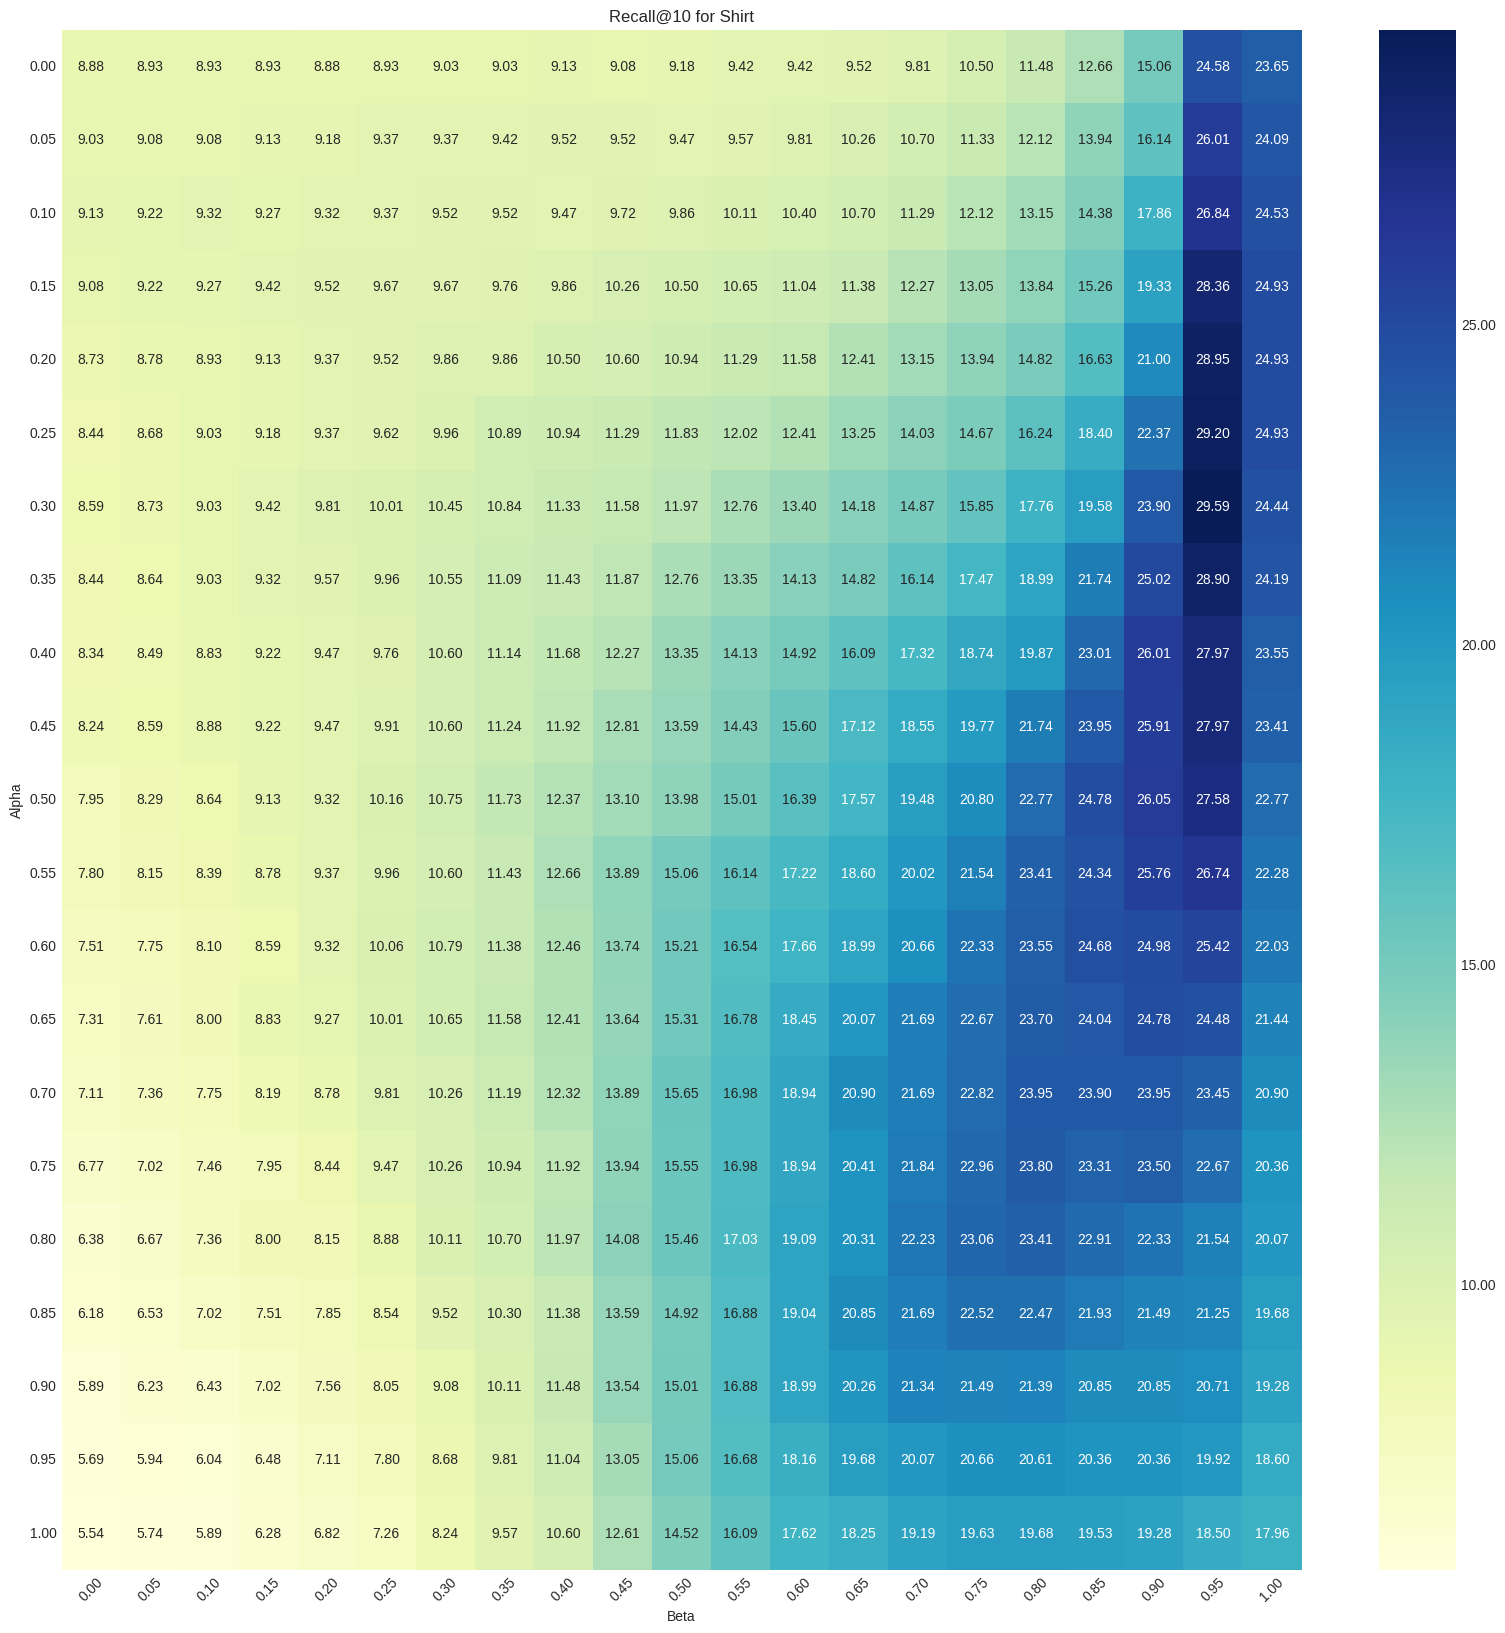

In [32]:
prepare_and_plot_recall_pivot(shirt_recall_at10, "Recall@10 for Shirt")

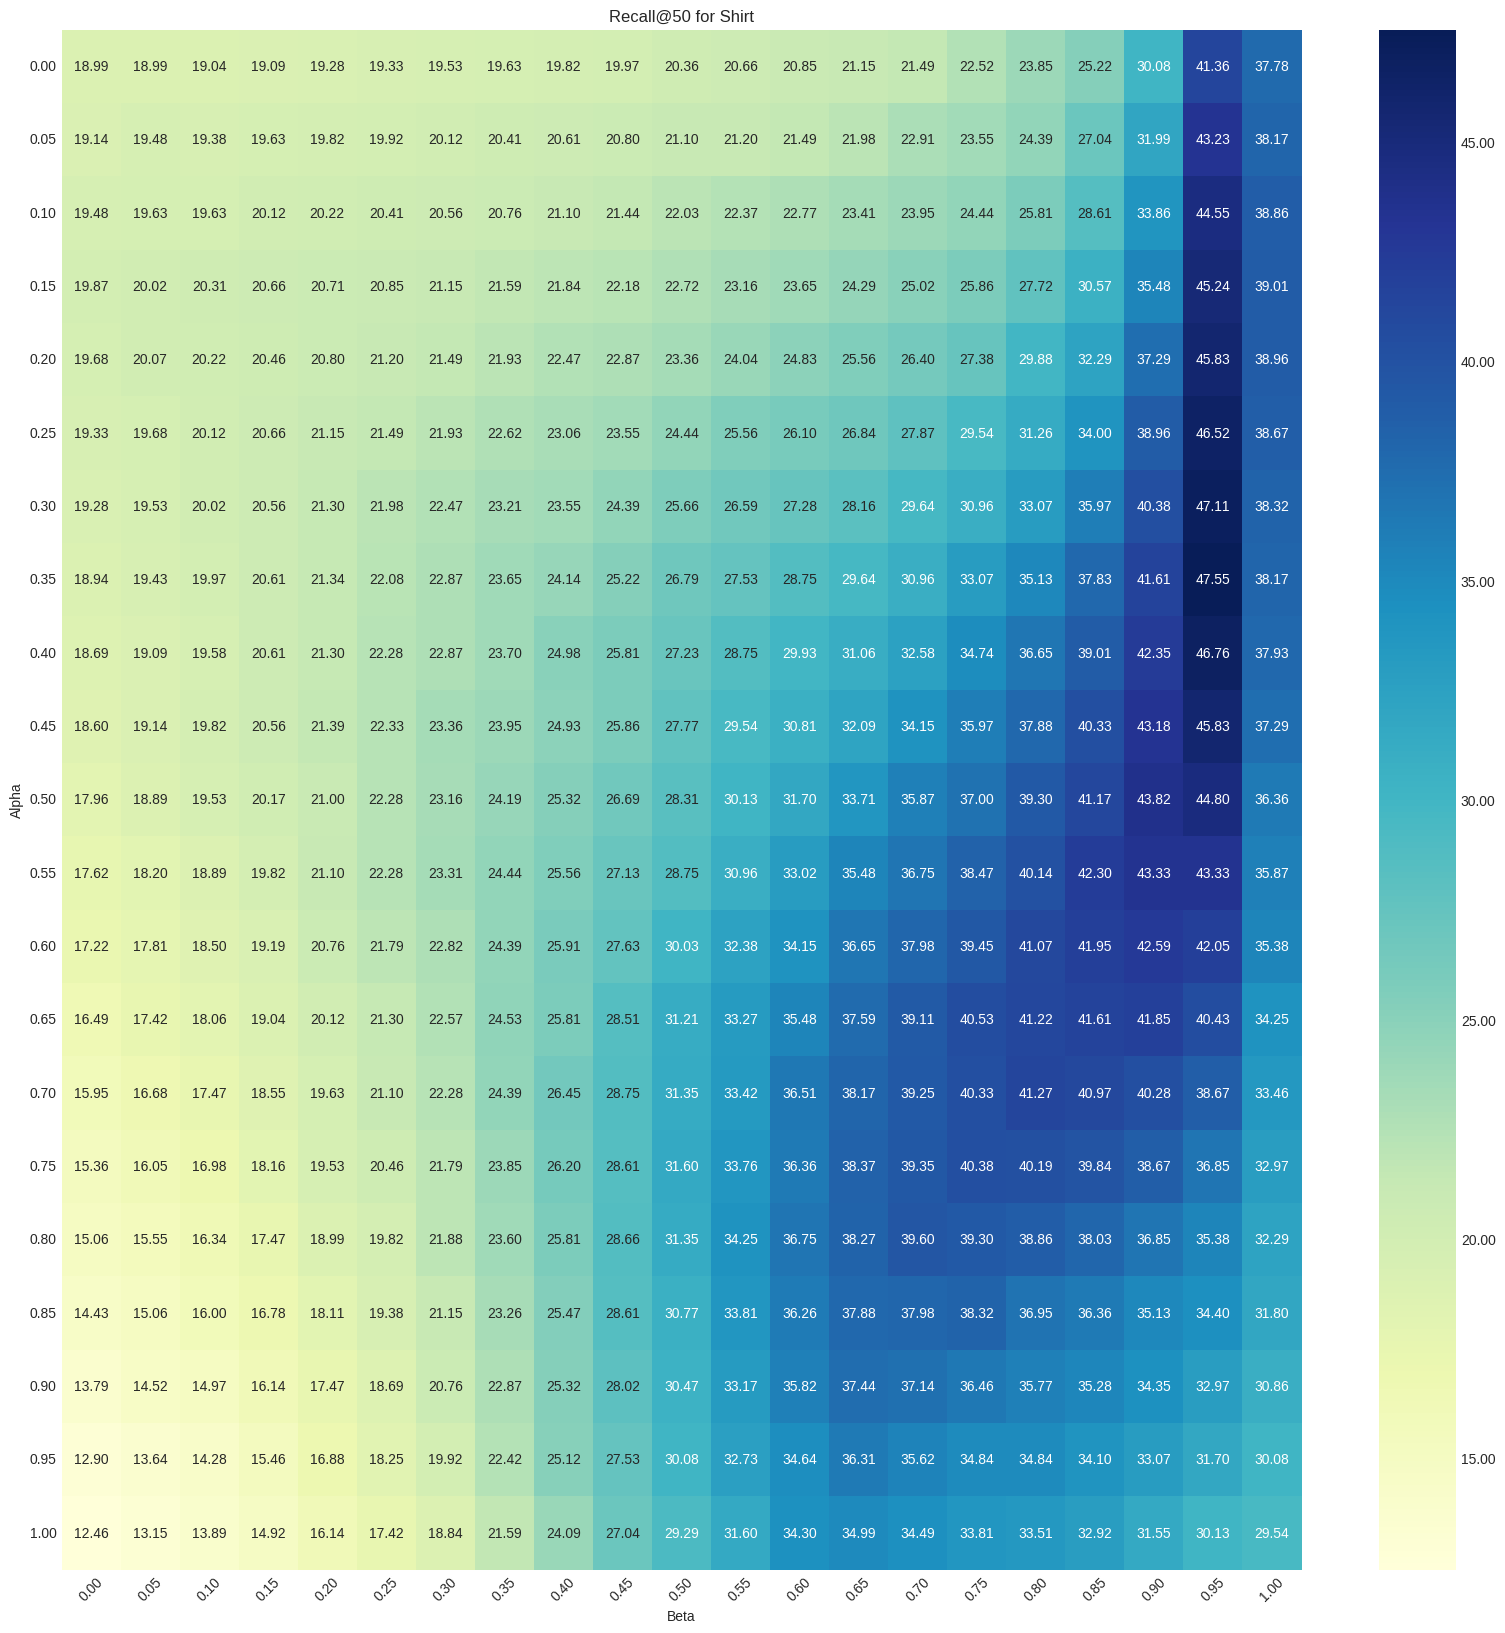

In [33]:
prepare_and_plot_recall_pivot(shirt_recall_at50, "Recall@50 for Shirt")

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Plot the recall at 10 and 50 for Dress</div>

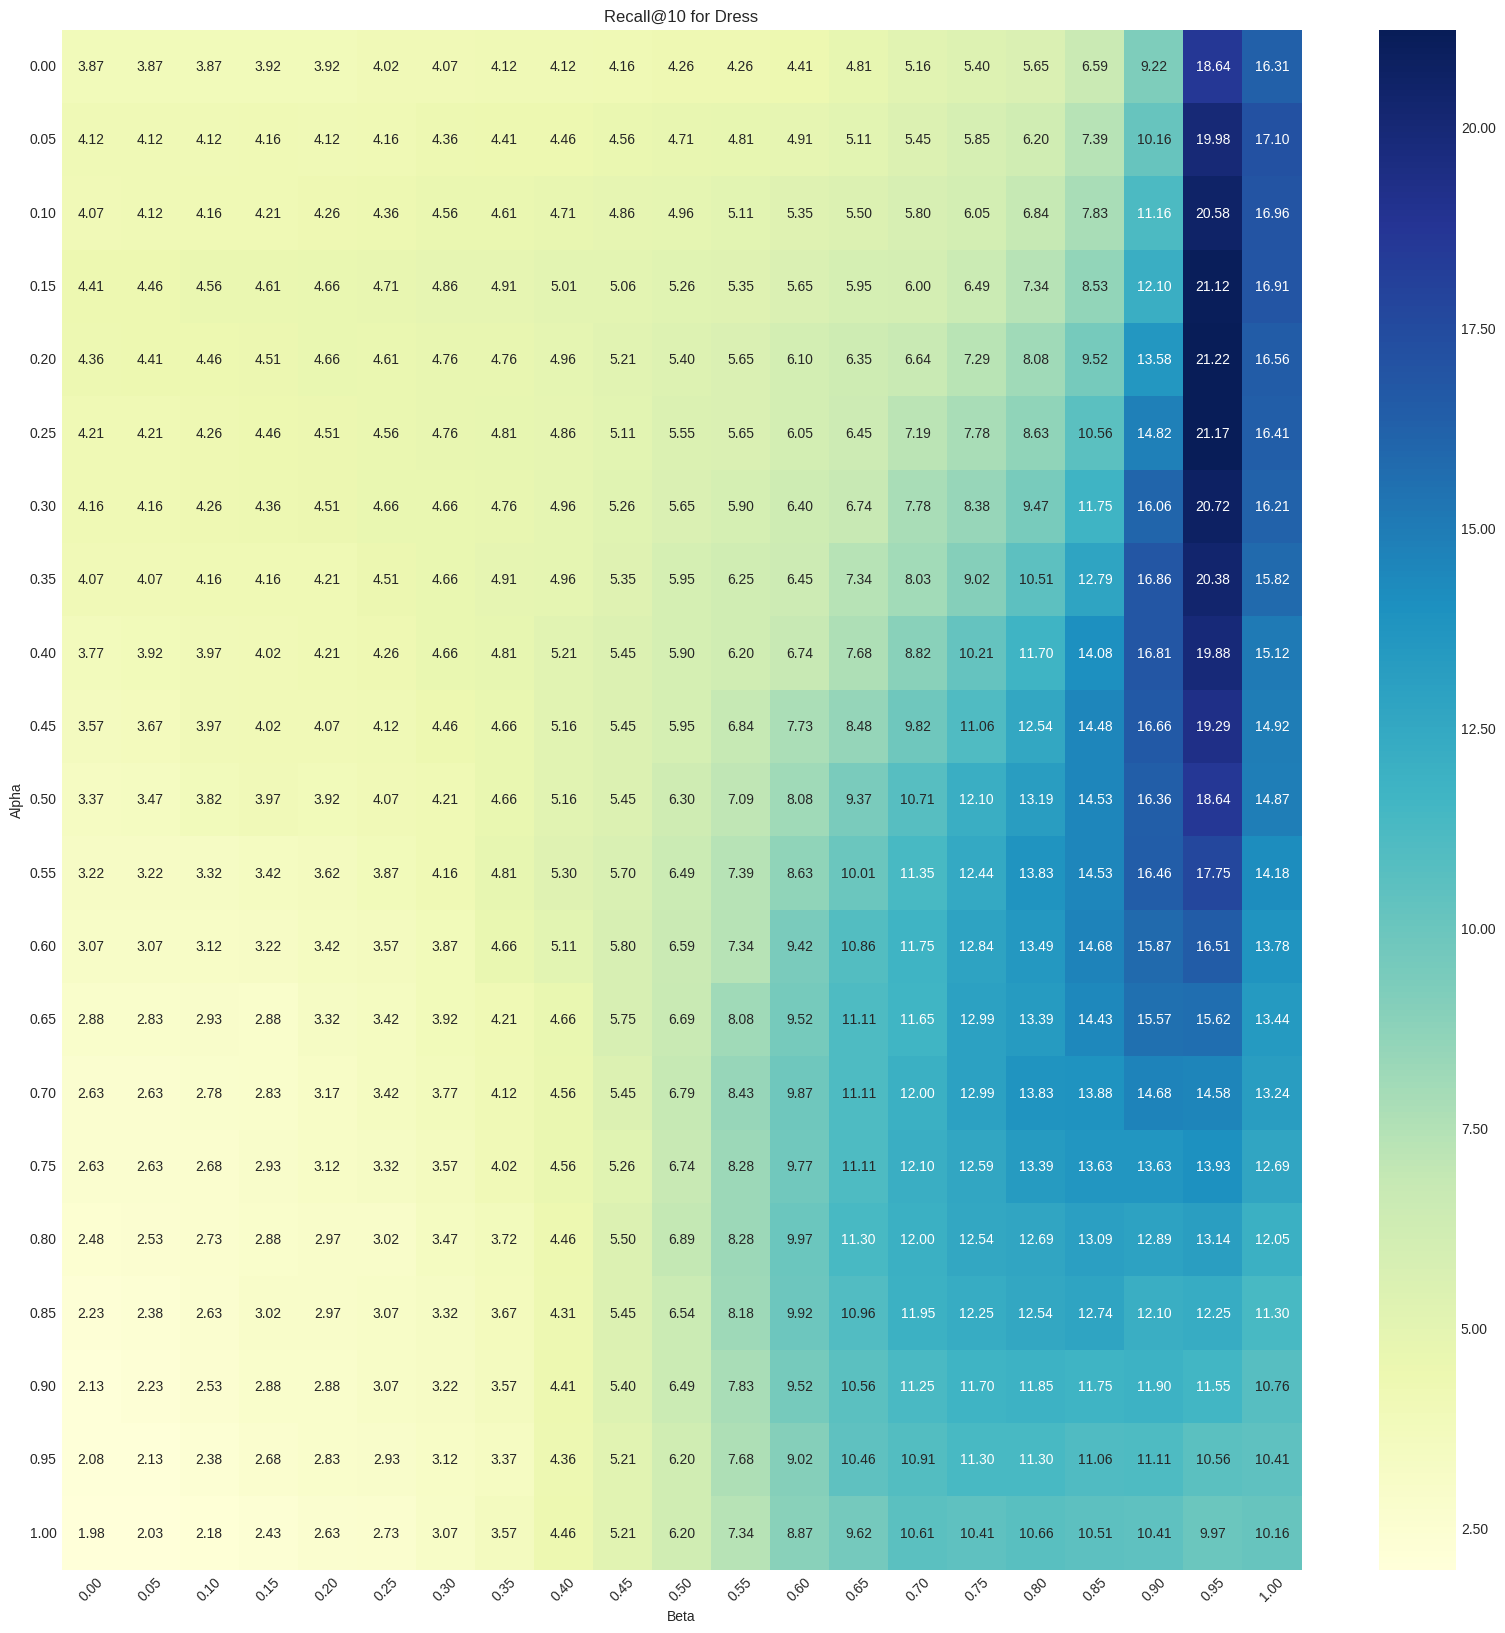

In [34]:
prepare_and_plot_recall_pivot(dress_recall_at10, "Recall@10 for Dress")

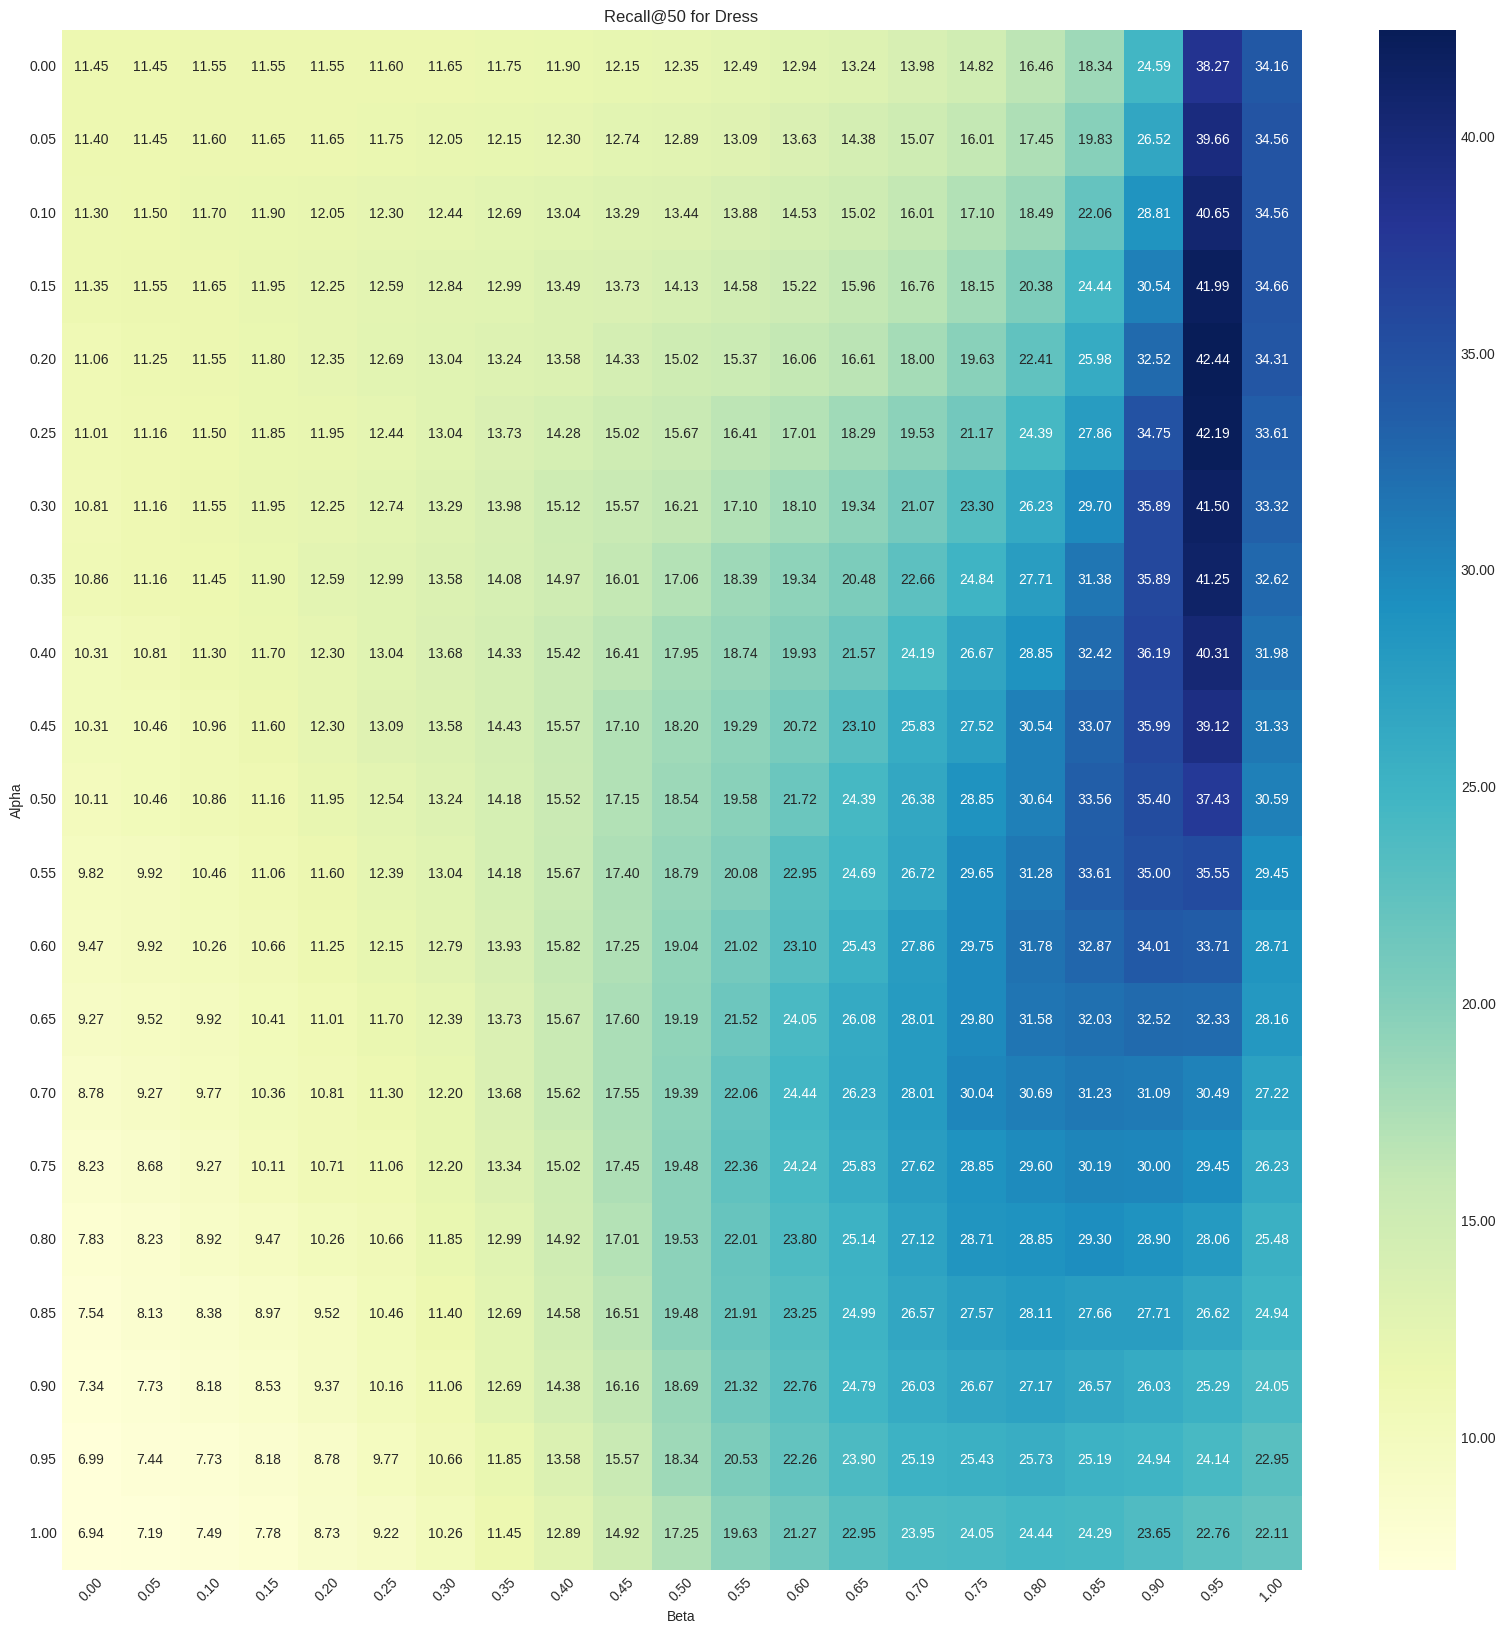

In [35]:
prepare_and_plot_recall_pivot(dress_recall_at50, "Recall@50 for Dress")

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Plot the recall at 10 and 50 for TopTee</div>

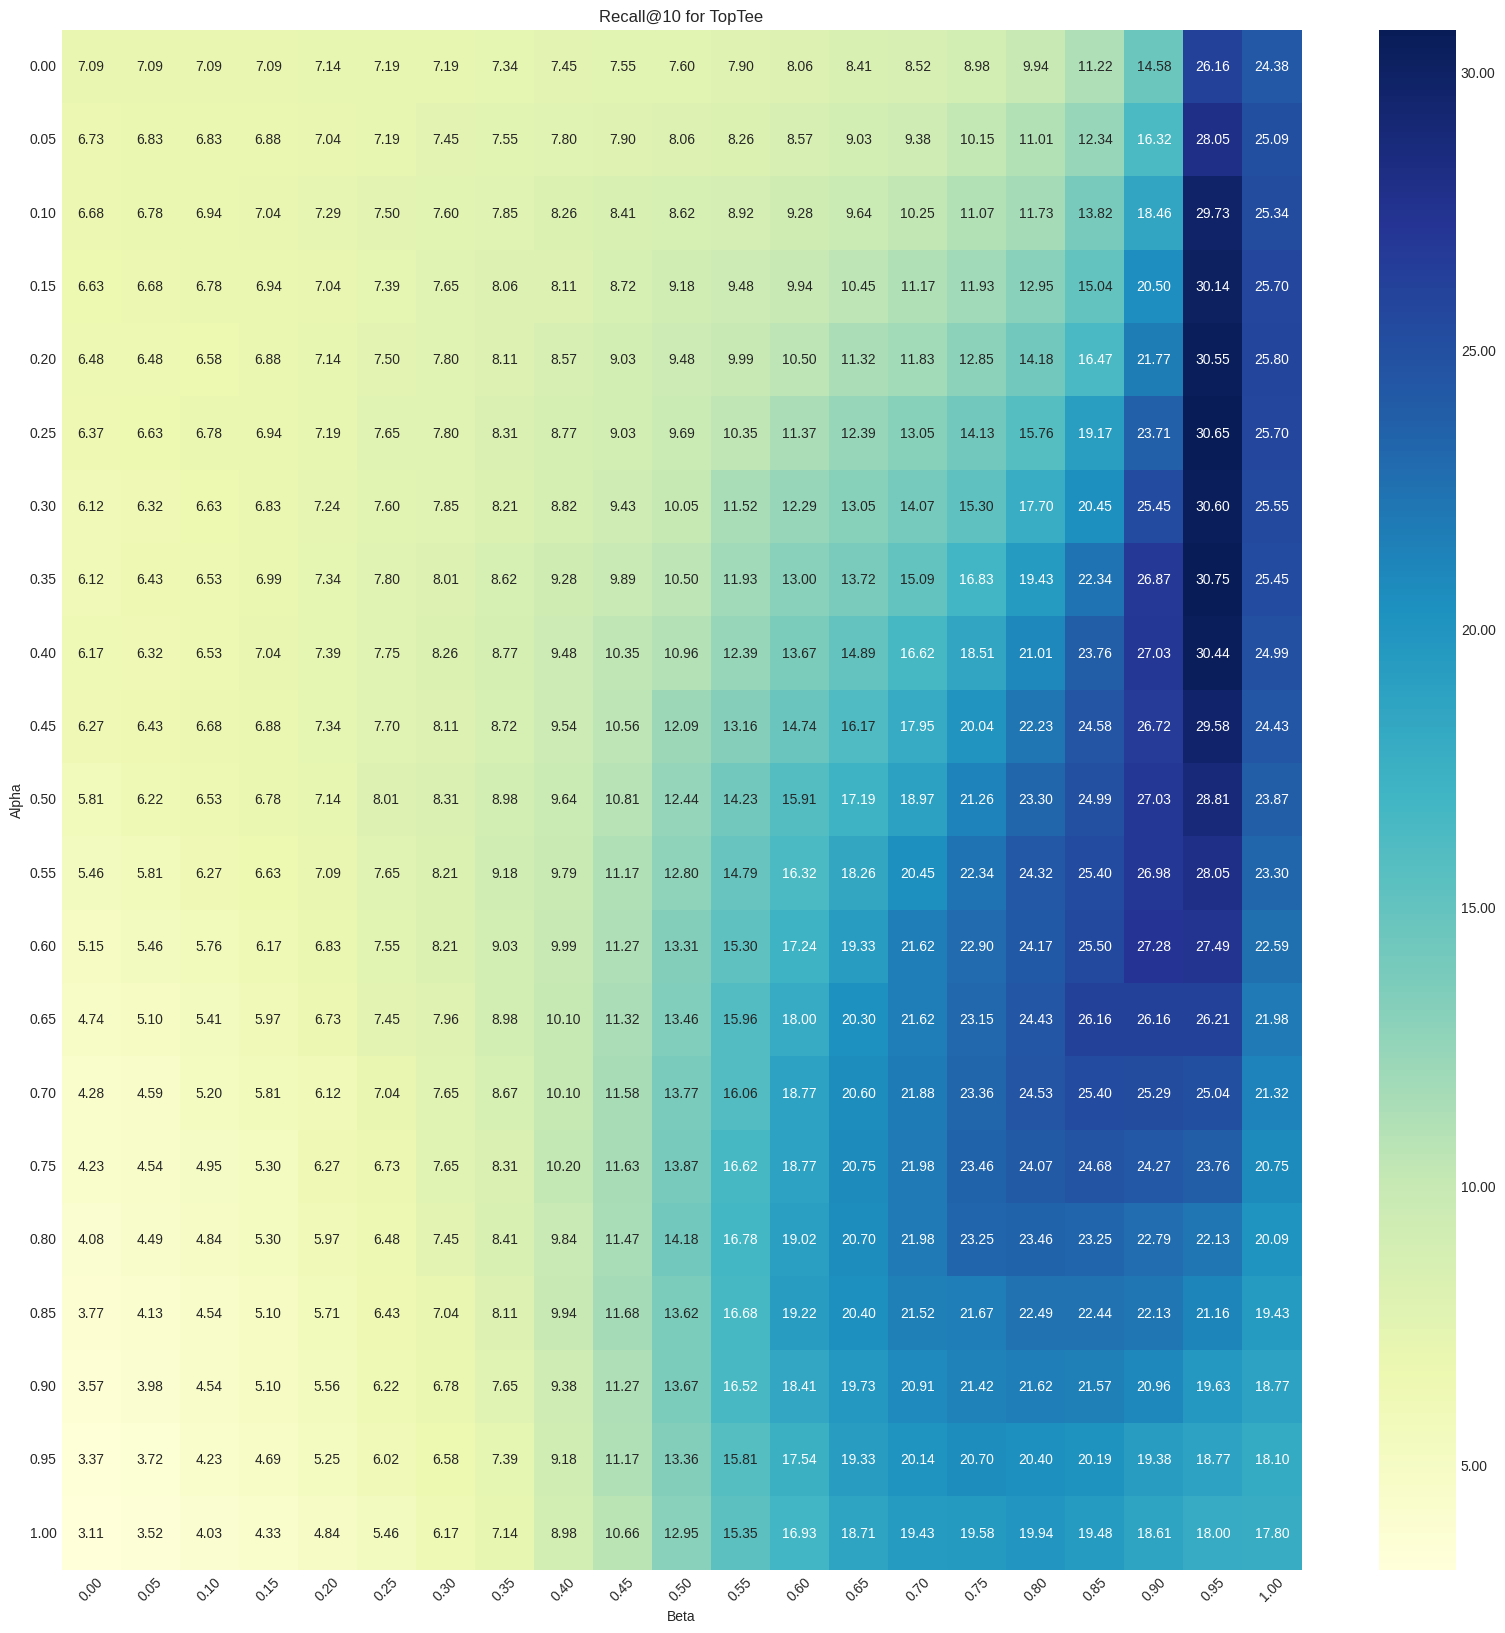

In [36]:
prepare_and_plot_recall_pivot(toptee_recall_at10, "Recall@10 for TopTee")

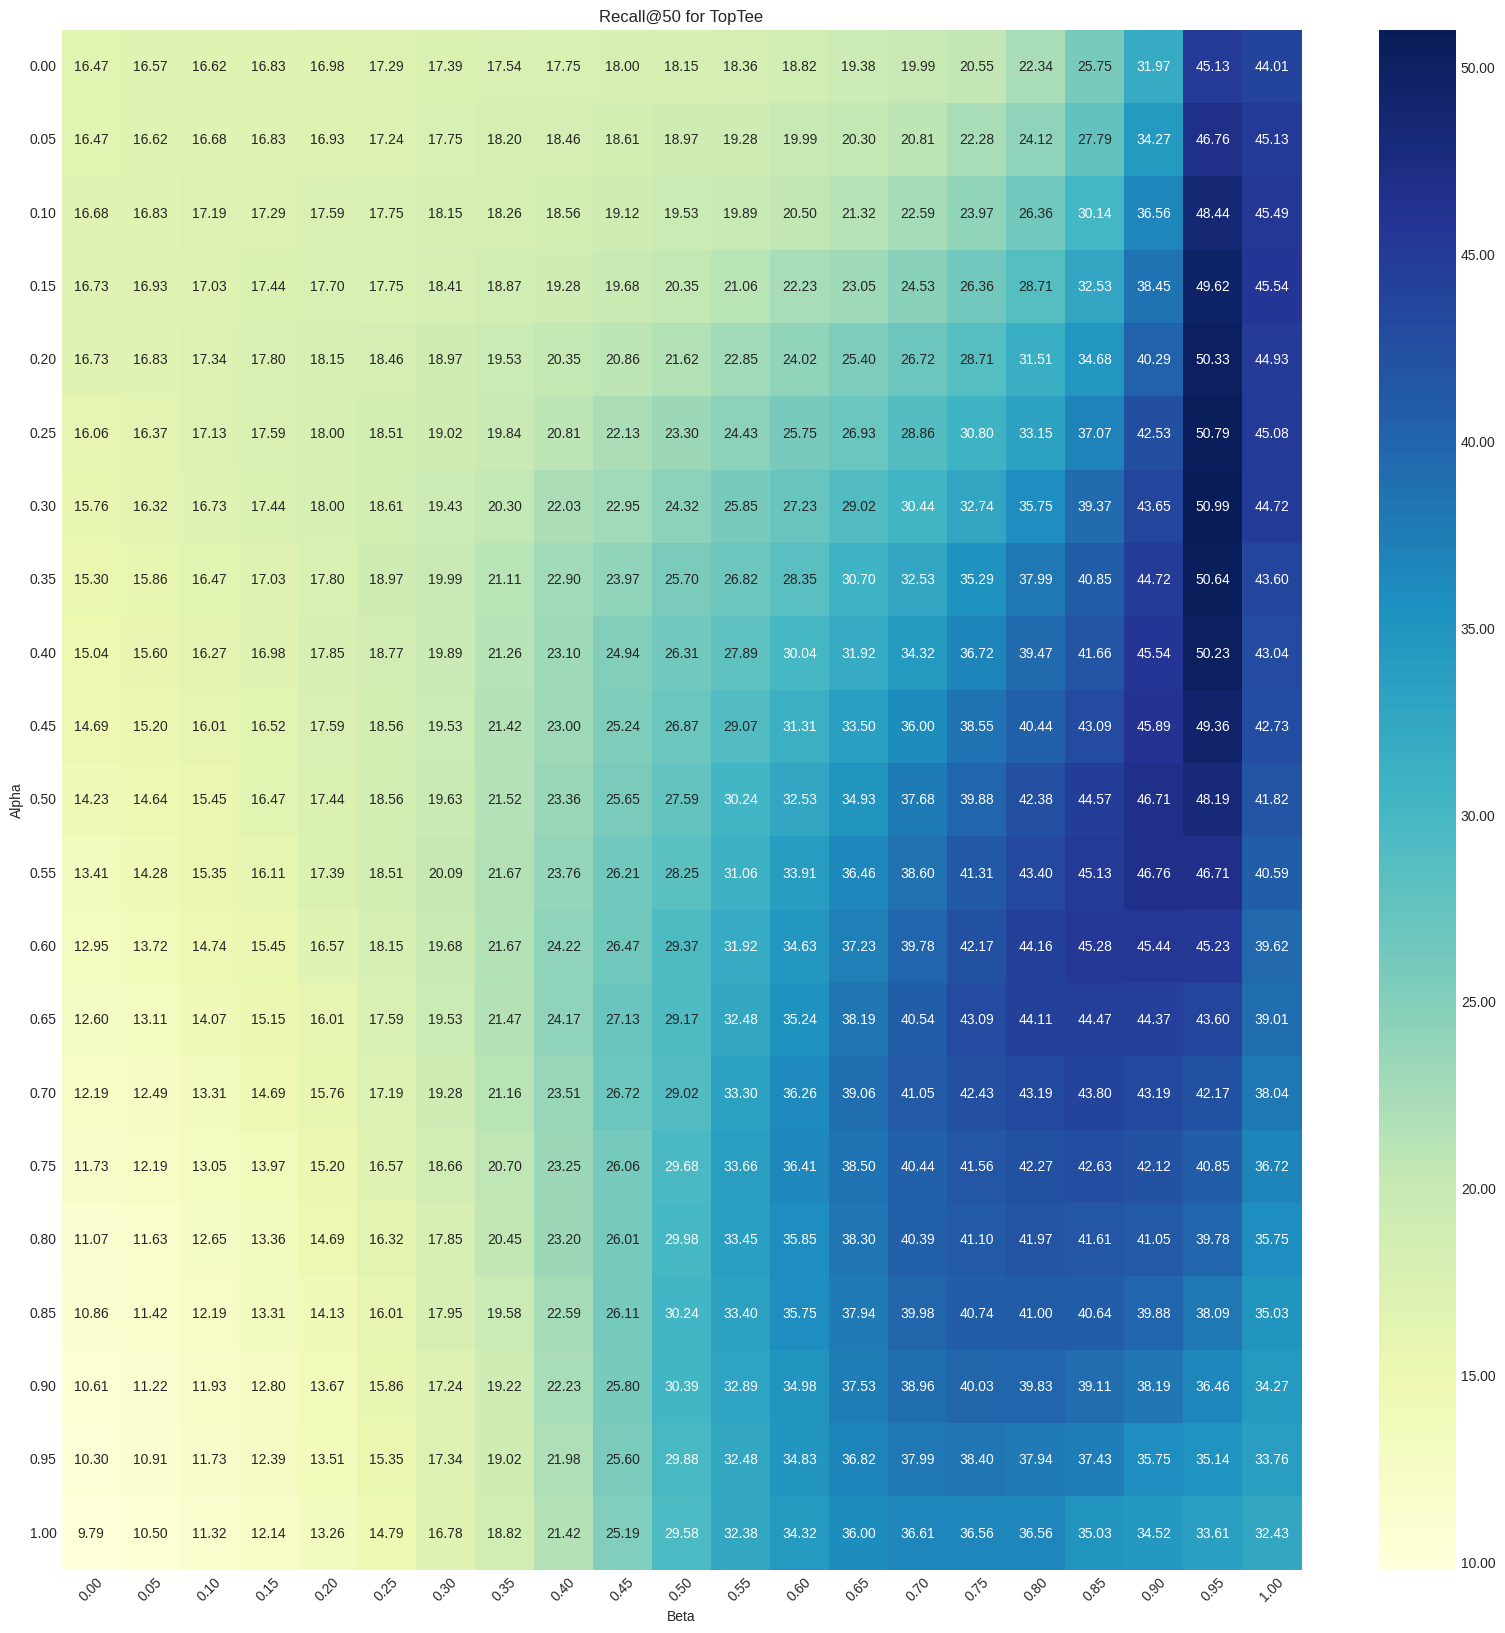

In [37]:
prepare_and_plot_recall_pivot(toptee_recall_at50, "Recall@50 for TopTee")

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Plot the average recall at 10 and 50 for all categories</div>

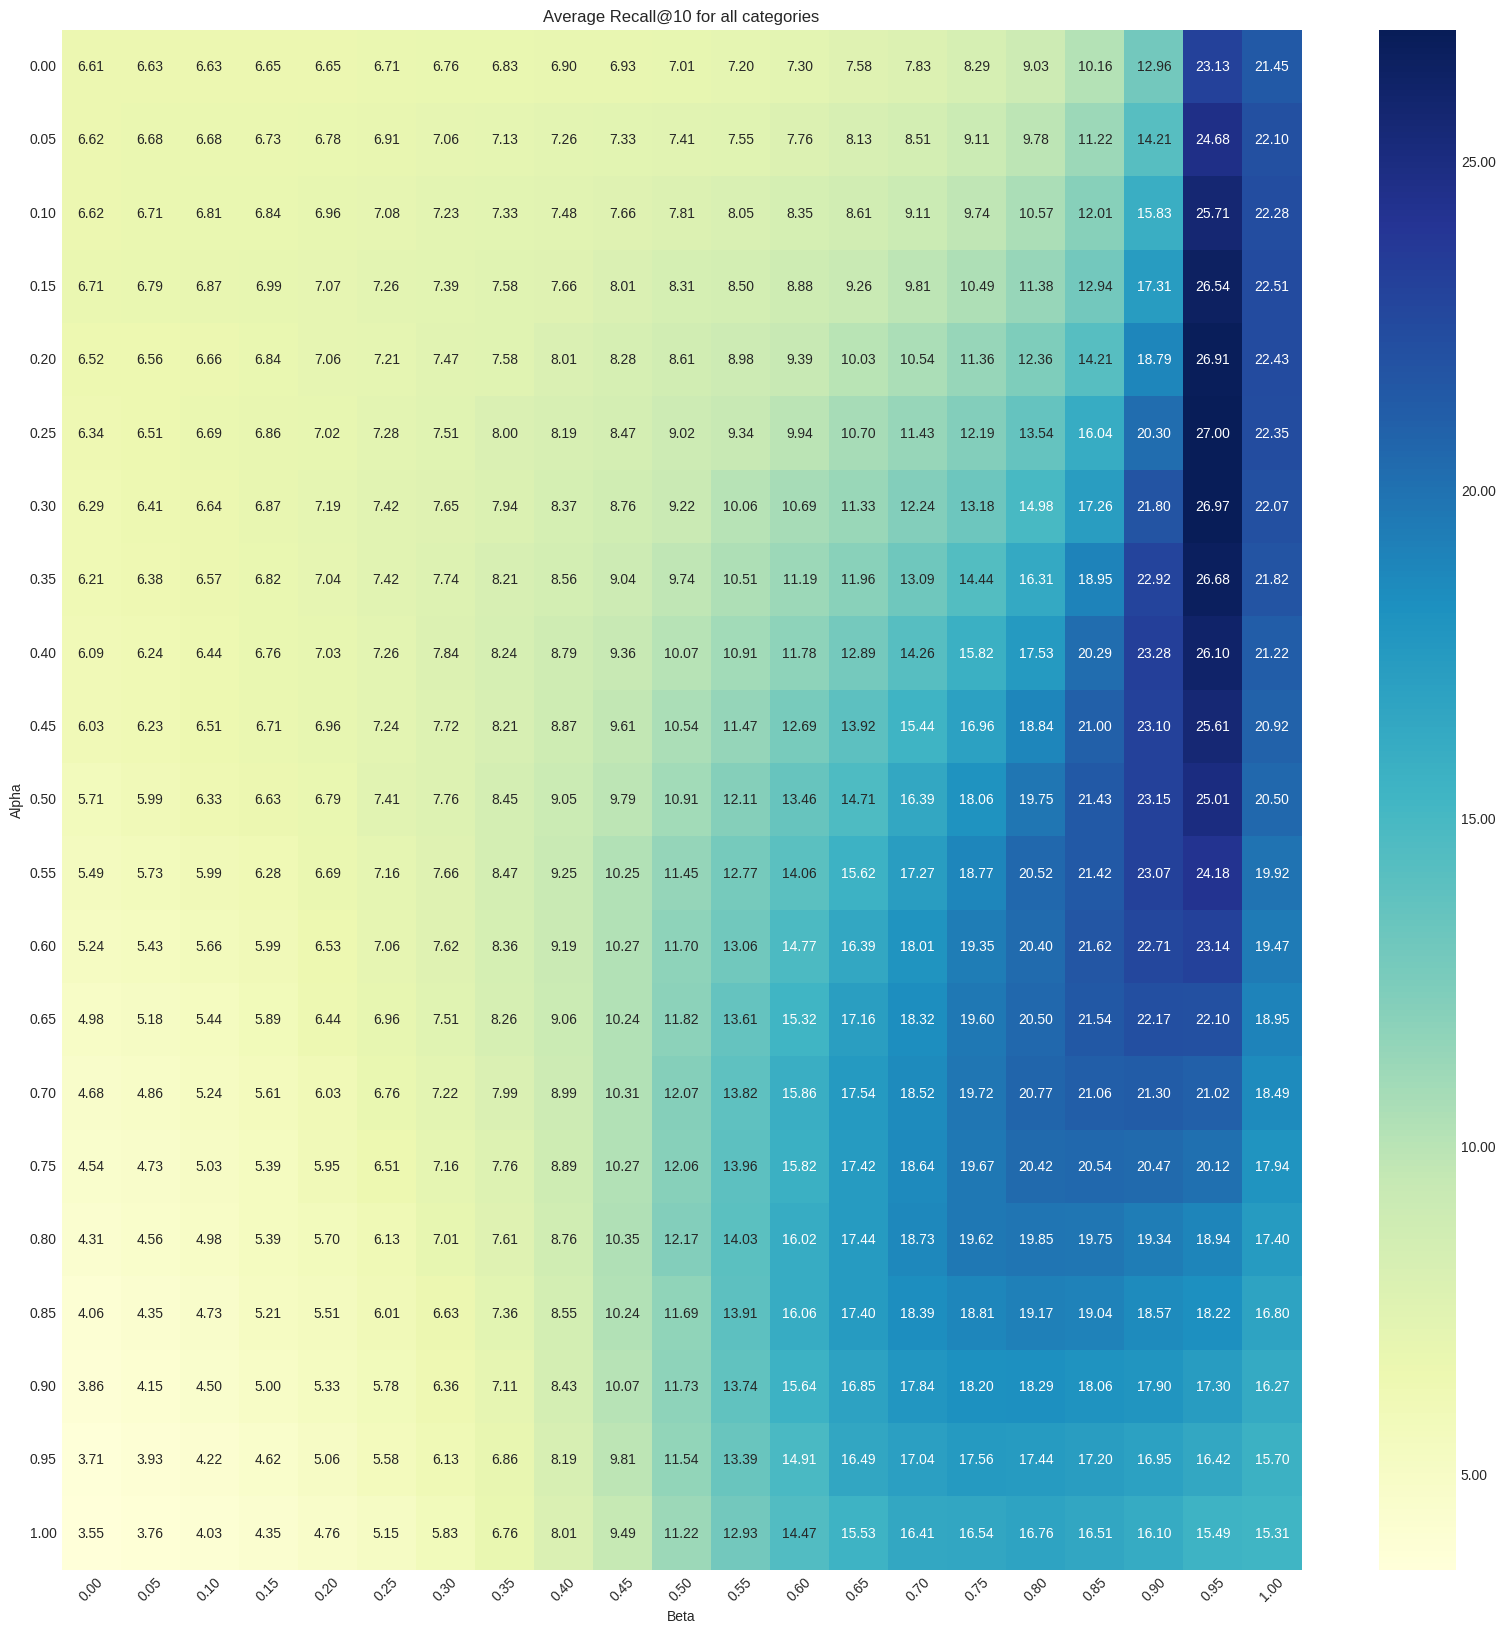

In [38]:
prepare_and_plot_recall_pivot(average_recall_at10, "Average Recall@10 for all categories")

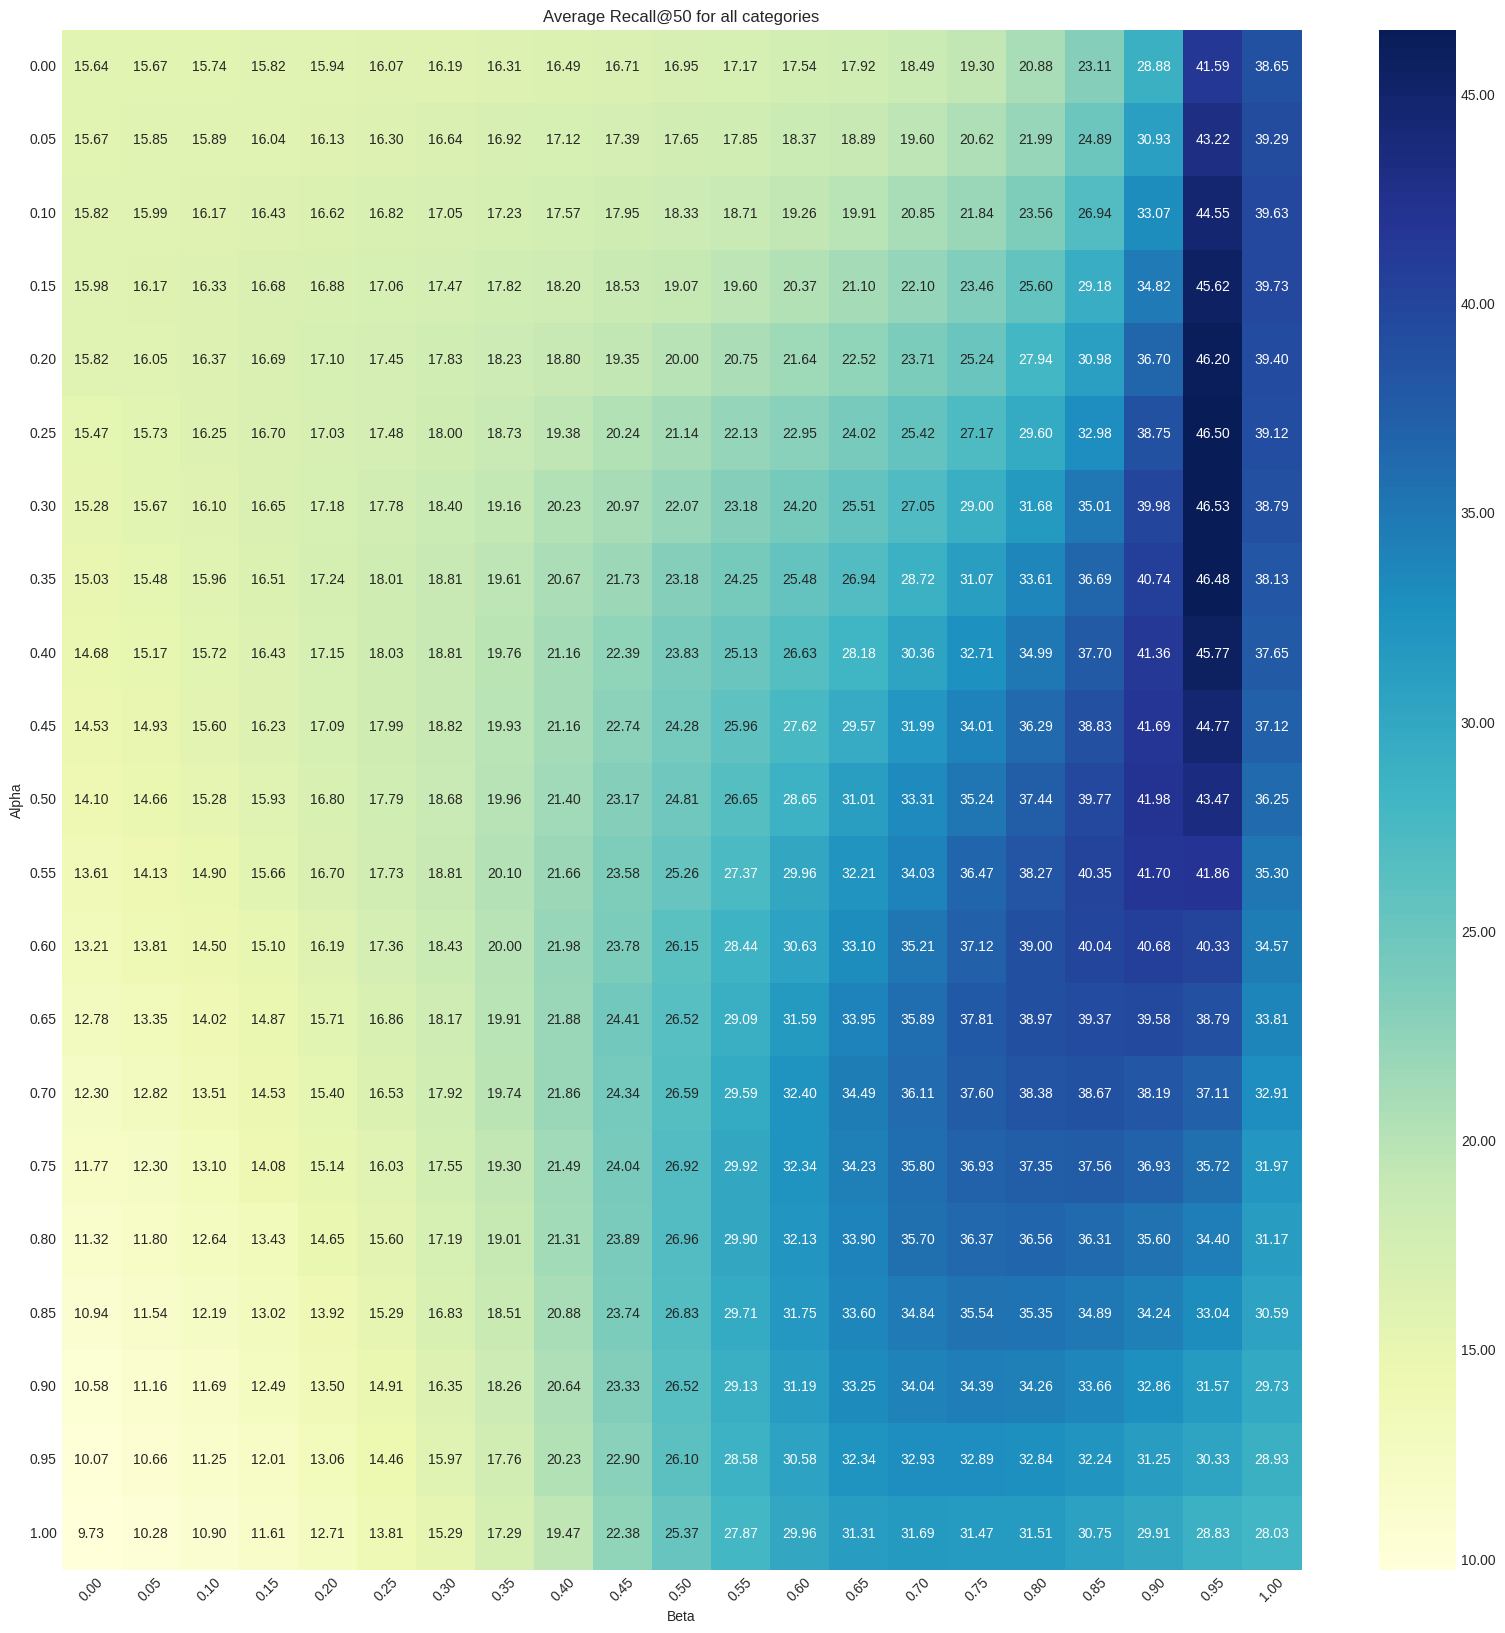

In [39]:
prepare_and_plot_recall_pivot(average_recall_at50, "Average Recall@50 for all categories")

# <div style="font-family: 'Garamond', serif; font-size: 22px; color: #ffffff; background-color: #34568B; text-align: center; padding: 15px; border-radius: 10px; border: 2px solid #FF6F61; box-shadow: 0 6px 12px rgba(0, 0, 0, 0.3); margin-bottom: 20px;">Step 5: View some sample of the result</div>

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Define the function to compute the results</div>

In [40]:
def compute_results(
    dress_type: str,
    combining_function: callable,
    blip_text_encoder: torch.nn.Module,
    blip_img_encoder: torch.nn.Module,
    text_captions: List[dict],
    preprocess: callable,
    alpha: float = 0.65
) -> Tuple[torch.tensor, List[str], List[str]]:
    """
    View sample results on FashionIQ dataset combining text and image distances.
    
    :param dress_type: FashionIQ category on which perform the retrieval
    :param combining_function:function which takes as input (image_features, text_features) and outputs the combined features
    :param blip_text_encoder: BLIP text model
    :param blip_img_encoder: BLIP image model
    :param text_captions: text captions for the FashionIQ dataset
    :param preprocess: preprocess pipeline
    :param alpha: alpha value for combining text and image distances
    
    :return: [(image_path, text_caption, candidate_image_paths)]
    """
    global cache
    cache_key = f"{dress_type}_cache"
    blip_text_encoder = blip_text_encoder.float().eval()
    blip_img_encoder = blip_img_encoder.float().eval()

    if cache_key not in cache:
        # Define the validation datasets and extract the index features
        classic_val_dataset = FashionIQDataset('val', [dress_type], 'classic', preprocess)

        multiple_index_features, multiple_index_names = [], []

        for i in range(3):
            index_features, index_names, _ = extract_index_features_with_text_captions(
                classic_val_dataset,
                blip_text_encoder,
                text_captions,
                i + 1
            )
            multiple_index_features.append(index_features)
            multiple_index_names.append(index_names)

        image_index_features, image_index_names = extract_index_features(classic_val_dataset, blip_img_encoder)

        cache[cache_key] = {
            "multiple_index_features": multiple_index_features,
            "multiple_index_names": multiple_index_names,
            "image_index_features": image_index_features,
            "image_index_names": image_index_names
        }
    else:
        multiple_index_features = cache[cache_key]["multiple_index_features"]
        multiple_index_names = cache[cache_key]["multiple_index_names"]
        image_index_features = cache[cache_key]["image_index_features"]
        image_index_names = cache[cache_key]["image_index_names"]

    relative_val_dataset = FashionIQDataset('val', [dress_type], 'relative', preprocess)

    all_text_distances = []

    # Compute distances for individual text features
    for text_features, text_names in zip(multiple_index_features, multiple_index_names):
        # Generate text predictions and normalize features
        predicted_text_features, target_names = generate_fiq_val_predictions(
            blip_text_encoder, relative_val_dataset,
            combining_function, text_names,
            text_features)
        # Normalize features
        text_features = F.normalize(text_features, dim=-1)
        predicted_text_features = F.normalize(predicted_text_features, dim=-1)

        # Compute cosine similarity and convert to distance
        cosine_similarities = torch.mm(predicted_text_features, text_features.T)
        distances = 1 - cosine_similarities
        all_text_distances.append(distances)

    predicted_image_features, target_names = generate_fiq_val_predictions(
        blip_text_encoder, relative_val_dataset,
        combining_function, image_index_names,
        image_index_features)

    # Normalize and compute distances
    image_index_features = F.normalize(image_index_features, dim=-1).float()
    image_distances = 1 - predicted_image_features @ image_index_features.T

    # Merge text distances
    merged_text_distances = torch.mean(torch.stack(all_text_distances), dim=0)

    merged_distances = alpha * merged_text_distances + (1 - alpha) * image_distances

    sorted_indices = torch.argsort(merged_distances, dim=-1).cpu()
    sorted_index_names = np.array(image_index_names if image_index_names else multiple_index_names[0])[sorted_indices]
    labels = torch.tensor(
        sorted_index_names == np.repeat(np.array(target_names),
                                        len(image_index_names if image_index_names else multiple_index_names[
                                            0])).reshape(len(target_names), -1))
    assert torch.equal(torch.sum(labels, dim=-1).int(), torch.ones(len(target_names)).int())
    recall_at10 = (torch.sum(labels[:, :10]) / len(labels)).item() * 100
    recall_at50 = (torch.sum(labels[:, :50]) / len(labels)).item() * 100

    print(f"Recall at 10: {recall_at10}")
    print(f"Recall at 50: {recall_at50}")

    return sorted_indices, image_index_names, target_names

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Compute the results for the Dress category</div>

In [41]:
sorted_indices_dress, image_index_names_dress, target_names_dress = compute_results(
    'dress',
    get_combing_function_with_beta(0.95),
    blip_text_encoder,
    blip_img_encoder,
    text_captions,
    preprocess,
    alpha=0.3
)

FashionIQ val - ['dress'] dataset in relative mode initialized


100%|██████████| 64/64 [00:01<00:00, 49.25it/s]


Recall at 10: 20.723846554756165

Recall at 50: 41.4972722530365

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Compute the results for the Shirt category</div>

In [42]:
sorted_indices_shirt, image_index_names_shirt, target_names_shirt = compute_results(
    'shirt',
    get_combing_function_with_beta(0.95),
    blip_text_encoder,
    blip_img_encoder,
    text_captions,
    preprocess,
    alpha=0.3
)

FashionIQ val - ['shirt'] dataset in relative mode initialized


100%|██████████| 64/64 [00:01<00:00, 51.94it/s]


Recall at 10: 29.58783209323883

Recall at 50: 47.105005383491516

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Compute the results for the TopTee category</div>

In [43]:
sorted_indices_toptee, image_index_names_toptee, target_names_toptee = compute_results(
    'toptee',
    get_combing_function_with_beta(0.95),
    blip_text_encoder,
    blip_img_encoder,
    text_captions,
    preprocess,
    alpha=0.3
)

FashionIQ val - ['toptee'] dataset in relative mode initialized


100%|██████████| 62/62 [00:01<00:00, 50.35it/s]


Recall at 10: 30.59663474559784

Recall at 50: 50.99439024925232

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Prepare the ground truth data</div>

In [ ]:
def prepare_ground_truths(json_data):
    """
    Prepare ground truth data from the JSON structure.
    
    :param json_data: JSON data containing target and candidate matches with captions
    :return: Dictionary mapping targets to lists of tuples (candidates and captions)
    """
    ground_truths = {}
    for entry in json_data:
        target = entry['target']
        candidate = entry['candidate']
        captions = entry['captions']
        if target not in ground_truths:
            ground_truths[target] = []
        ground_truths[target].append((candidate, captions))  # Store as a tuple
    return ground_truths

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Plot the retrieval results for a query</div>

In [ ]:
def plot_retrieval_results_of_i(sorted_indices, image_index_names, target_names, ground_truths, top_k=5, i=0):
    """
    Plot retrieval results for a specific query showing the query and its top retrieved images, highlighting ground truths
    and displaying associated captions to the left of the query image.

    :param sorted_indices: 2D tensor or array with sorted indices of retrieved images per query.
    :param image_index_names: List of image paths corresponding to indices in sorted_indices.
    :param target_names: List of names or descriptions for each query.
    :param ground_truths: Dictionary mapping target names to lists of tuples (candidates and captions).
    :param top_k: Number of top retrieved results to display per query.
    :param i: Index of the query to display.
    """
    query_index = i
    retrival_result_images = [image_index_names[j] for j in sorted_indices[query_index]][:top_k]
    ground_truth_target = target_names[query_index]
    query_img_path, query_captions = ground_truths.get(ground_truth_target, [('', '')])[0]

    fig = plt.figure(figsize=(30, 5))
    gs = GridSpec(1, top_k + 2, figure=fig)
    query_img = Image.open(f'../fashionIQ_dataset/images/{query_img_path}.png')

    # Subplot for the caption text to the left of the query image
    ax_text = fig.add_subplot(gs[0, 0])
    query_name = query_img_path
    query_captions = '\n'.join(sentences for sentences in query_captions)
    ax_text.text(0.5, 0.5, query_captions, va='center', ha='center')
    ax_text.axis('off')

    # Subplot for the query image
    ax_image = fig.add_subplot(gs[0, 1])
    ax_image.imshow(query_img)
    ax_image.set_title(f"Query: {query_name}", color='blue')
    ax_image.axis('off')

    for j, img_path in enumerate(retrival_result_images):
        img = Image.open(f'../fashionIQ_dataset/images/{img_path}.png')

        ax_result = fig.add_subplot(gs[0, j + 2])
        ax_result.imshow(img)

        # Check if this image is a ground truth and retrieve its captions
        if img_path == ground_truth_target:
            ax_result.set_title(f"{img_path}", color='green')
        else:
            ax_result.set_title(img_path)

        ax_result.axis('off')

    plt.tight_layout()
    plt.show()

In [ ]:
ground_truth_dress = prepare_ground_truths(json.load(open('../fashionIQ_dataset/captions/cap.dress.val.json')))
ground_truth_shirt = prepare_ground_truths(json.load(open('../fashionIQ_dataset/captions/cap.shirt.val.json')))
ground_truth_toptee = prepare_ground_truths(json.load(open('../fashionIQ_dataset/captions/cap.toptee.val.json')))

In [ ]:
plot_retrieval_results_of_i(sorted_indices_dress, image_index_names_dress, target_names_dress, ground_truth_dress, top_k=10, i=3)

# <div style="font-family: 'Garamond', serif; font-size: 22px; color: #ffffff; background-color: #34568B; text-align: center; padding: 15px; border-radius: 10px; border: 2px solid #FF6F61; box-shadow: 0 6px 12px rgba(0, 0, 0, 0.3); margin-bottom: 20px;">Step 6: Compare with alpha=0 (Same as the original BLIP4CIR)</div>

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Compute the results for the Dress category with alpha=0</div>

In [ ]:
sorted_indices_dress_origin, image_index_names_dress_origin, target_names_dress_origin = compute_results(
    'dress',
    combining_function_original,
    blip_text_encoder,
    blip_img_encoder,
    text_captions,
    preprocess,
    alpha=0
)

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Compute the results for the Shirt category with alpha=0</div>

In [ ]:
sorted_indices_shirt_origin, image_index_names_shirt_origin, target_names_shirt_origin = compute_results(
    'shirt',
    combining_function_original,
    blip_text_encoder,
    blip_img_encoder,
    text_captions,
    preprocess,
    alpha=0
)

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Compute the results for the TopTee category with alpha=0</div>

In [ ]:
sorted_indices_toptee_origin, image_index_names_toptee_origin, target_names_toptee_origin = compute_results(
    'toptee',
    combining_function_original,
    blip_text_encoder,
    blip_img_encoder,
    text_captions,
    preprocess,
    alpha=0
)

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Compare the results</div>

In [ ]:
def found_better_than_original(
        sorted_indices_origin, image_index_names_origin, target_names_origin,
        sorted_indices, image_index_names, target_names, top_k=10
) -> List[int]:
    """
    Return indices of queries where the new retrieval results are better than the original results based on the rank
    of the ground truth in the top_k results.

    Args:
        sorted_indices_origin (np.ndarray): 2D array of sorted indices by relevance per query for the original method.
        image_index_names_origin (List[str]): List of image names corresponding to indices in sorted_indices_origin.
        target_names_origin (List[str]): List of names or descriptions for each query for the original method.
        sorted_indices (np.ndarray): 2D array of sorted indices by relevance per query for the new method.
        image_index_names (List[str]): List of image names corresponding to indices in sorted_indices.
        target_names (List[str]): List of target names each query is supposed to retrieve.
        top_k (int): Number of top retrieved results to consider per query.

    Returns:
        List[int]: List of indices where the new method outperforms the original method in terms of the rank of the
        ground truth target.
    """
    better_indices = []
    total_queries = len(target_names)  # Assuming the same number of queries for both sets

    for index in range(total_queries):
        # Find the index of the ground truth in the top_k results of the original method
        new_rank = [image_index_names[i] for i in sorted_indices[index]].index(target_names[index])
        origin_rank = [image_index_names_origin[i] for i in sorted_indices_origin[index]].index(target_names_origin[index])

        if new_rank <= top_k < origin_rank:
            better_indices.append(index)

    return better_indices

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Compare the results for the Dress category</div>

In [ ]:
become_better = found_better_than_original(
    sorted_indices_dress_origin, image_index_names_dress_origin, target_names_dress_origin,
    sorted_indices_dress, image_index_names_dress, target_names_dress,
    top_k=10
)

len(become_better), become_better[:10]

In [ ]:
become_worse = found_better_than_original(
    sorted_indices_dress, image_index_names_dress, target_names_dress,
    sorted_indices_dress_origin, image_index_names_dress_origin, target_names_dress_origin,
    top_k=10
)

len(become_worse), become_worse[:10]

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Compare the results for the Shirt category</div>

In [ ]:
become_better = found_better_than_original(
    sorted_indices_shirt_origin, image_index_names_shirt_origin, target_names_shirt_origin,
    sorted_indices_shirt, image_index_names_shirt, target_names_shirt,
    top_k=10
)

len(become_better), become_better[:10]

In [ ]:
become_worse = found_better_than_original(
    sorted_indices_shirt, image_index_names_shirt, target_names_shirt,
    sorted_indices_shirt_origin, image_index_names_shirt_origin, target_names_shirt_origin,
    top_k=10
)

len(become_worse), become_worse[:10]

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Compare the results for the TopTee category</div>

In [ ]:
become_better = found_better_than_original(
    sorted_indices_toptee_origin, image_index_names_toptee_origin, target_names_toptee_origin,
    sorted_indices_toptee, image_index_names_toptee, target_names_toptee,
    top_k=10
)

len(become_better), become_better[:10]

In [ ]:
become_worse = found_better_than_original(
    sorted_indices_toptee, image_index_names_toptee, target_names_toptee,
    sorted_indices_toptee_origin, image_index_names_toptee_origin, target_names_toptee_origin,
    top_k=10
)

len(become_worse), become_worse[:10]

# <div style="font-family: 'Garamond', serif; font-size: 22px; color: #ffffff; background-color: #34568B; text-align: center; padding: 15px; border-radius: 10px; border: 2px solid #FF6F61; box-shadow: 0 6px 12px rgba(0, 0, 0, 0.3); margin-bottom: 20px;">Step 7: Visualize the comparison</div>

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Plot the results for the Dress category</div>

In [ ]:
plot_retrieval_results_of_i(sorted_indices_dress, image_index_names_dress, target_names_dress, ground_truth_dress, top_k=10, i=1)

In [ ]:
plot_retrieval_results_of_i(sorted_indices_dress_origin, image_index_names_dress_origin, target_names_dress_origin, ground_truth_dress, top_k=10, i=1)

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Plot the results for the Shirt category</div>

In [ ]:
plot_retrieval_results_of_i(sorted_indices_shirt, image_index_names_shirt, target_names_shirt, ground_truth_shirt, top_k=10, i=1)

In [ ]:
plot_retrieval_results_of_i(sorted_indices_shirt_origin, image_index_names_shirt_origin, target_names_shirt_origin, ground_truth_shirt, top_k=10, i=1)

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Plot the results for the TopTee category</div>

In [ ]:
plot_retrieval_results_of_i(sorted_indices_toptee, image_index_names_toptee, target_names_toptee, ground_truth_toptee, top_k=10, i=2)

In [ ]:
plot_retrieval_results_of_i(sorted_indices_toptee_origin, image_index_names_toptee_origin, target_names_toptee_origin, ground_truth_toptee, top_k=10, i=2)